# Industrial Control System Power System (ICS) Cyber Attacks Detection Research.

Machine learning classification techniques for discriminating power system disturbances, the system used for evaluation is described as well as the different natural and man-made scenarios.

Types of Scenarios:
1. Short-circuit fault – this is a short in a power line and can occur in various locations along the line, the location is indicated by the percentage range.
2. Line maintenance –one or more breakers are opened through the remote relay trip command for maintenance.
3. Remote tripping command injection (Attack) – this is an attack that sends a command to a relay which causes a breaker to open. It can only be done once an attacker has penetrated outside defenses.
4. Relay setting change (Attack) – relays are configured with a distance protection scheme and the attacker changes the setting to disable the relay function such that relay will not trip for a valid fault or a valid command.
5. Data Injection (Attack) – here we imitate a valid fault by changing values to parameters such as current, voltage, sequence components etc., in order to blind the operator and cause a black out.

The classification of events was performed using three different classification schemes:

• Multiclass - Each of the 37 event scenarios, which included attack events, natural events, and normal operations, was its own class and was predicted independently by the learners,

• Three-class – The 37 event scenarios were grouped into 3 classes: attack events (28 events), natural event (8 events) or “No events” (1 event).

• Binary – The 37 event scenarios were grouped as either an attack (28 events) or normal operations (9 events). The data was drawn from 15 data sets which included thousands of individual samples of measurements throughout the power system for each event type.

Datasets, that we are talking about were randomly sampled at 1% to reduce the size and evaluate the effectiveness of small sample sizes. For this analysis, there was an average of 294 “No event” instances, 3,711 attack instances and 1,221 natural events instances used across the classification schemes. The date and time information were removed since scenarios were run sequentially and time and date would perfectly classify the data. For each of the three schemes, Multiclass, Three-class and Binary, we tested on Adaboost+JRipper learners on 15 datasets. When running the experiments we chose to use the tenfold or 10x cross validation methodology. When testing using this method we partitioned the dataset into 10 sets randomly selecting instances from each category. The model was built on a ninety percent selection from the data and tested on the remaining ten percent of the data to evaluate the learner’s performance. We repeated this for each learner and each dataset then taking the average over the fifteen datasets to summarize the results.

In [1]:
# Imports, settings and dataset view
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import FunctionTransformer
from collections import Counter
from sklearn.metrics import make_scorer, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import pickle

# Set pandas to show all columns when you print a dataframe
pd.set_option('display.max_columns', None)

# Global settings for dataset choosing
dataset = ["binaryAllNaturalPlusNormalVsAttacks", "multiclass", "triple"]
number = [n for n in range(1, 15)]
index = 0
relevant = "./Class/"+str(dataset[index])+"/data"+str(number[index])+".csv"
with open(relevant, 'rb') as file:
    df = pd.read_csv(file)
df.head()


,R1-PA1:VH,R1-PM1:V,R1-PA2:VH,R1-PM2:V,R1-PA3:VH,R1-PM3:V,R1-PA4:IH,R1-PM4:I,R1-PA5:IH,R1-PM5:I,R1-PA6:IH,R1-PM6:I,R1-PA7:VH,R1-PM7:V,R1-PA8:VH,R1-PM8:V,R1-PA9:VH,R1-PM9:V,R1-PA10:IH,R1-PM10:I,R1-PA11:IH,R1-PM11:I,R1-PA12:IH,R1-PM12:I,R1:F,R1:DF,R1-PA:Z,R1-PA:ZH,R1:S,R2-PA1:VH,R2-PM1:V,R2-PA2:VH,R2-PM2:V,R2-PA3:VH,R2-PM3:V,R2-PA4:IH,R2-PM4:I,R2-PA5:IH,R2-PM5:I,R2-PA6:IH,R2-PM6:I,R2-PA7:VH,R2-PM7:V,R2-PA8:VH,R2-PM8:V,R2-PA9:VH,R2-PM9:V,R2-PA10:IH,R2-PM10:I,R2-PA11:IH,R2-PM11:I,R2-PA12:IH,R2-PM12:I,R2:F,R2:DF,R2-PA:Z,R2-PA:ZH,R2:S,R3-PA1:VH,R3-PM1:V,R3-PA2:VH,R3-PM2:V,R3-PA3:VH,R3-PM3:V,R3-PA4:IH,R3-PM4:I,R3-PA5:IH,R3-PM5:I,R3-PA6:IH,R3-PM6:I,R3-PA7:VH,R3-PM7:V,R3-PA8:VH,R3-PM8:V,R3-PA9:VH,R3-PM9:V,R3-PA10:IH,R3-PM10:I,R3-PA11:IH,R3-PM11:I,R3-PA12:IH,R3-PM12:I,R3:F,R3:DF,R3-PA:Z,R3-PA:ZH,R3:S,R4-PA1:VH,R4-PM1:V,R4-PA2:VH,R4-PM2:V,R4-PA3:VH,R4-PM3:V,R4-PA4:IH,R4-PM4:I,R4-PA5:IH,R4-PM5:I,R4-PA6:IH,R4-PM6:I,R4-PA7:VH,R4-PM7:V,R4-PA8:VH,R4-PM8:V,R4-PA9:VH,R4-PM9:V,R4-PA10:IH,R4-PM10:I,R4-PA11:IH,R4-PM11:I,R4-PA12:IH,R4-PM12:I,R4:F,R4:DF,R4-PA:Z,R4-PA:ZH,R4:S,control_panel_log1,control_panel_log2,control_panel_log3,control_panel_log4,relay1_log,relay2_log,relay3_log,relay4_log,snort_log1,snort_log2,snort_log3,snort_log4,marker
0,70.399324,127673.0908,-49.572308,127648.0176,-169.578319,127723.2374,65.689611,605.91099,-57.003571,626.78553,-173.589023,602.43190,70.422243,127673.0908,0.0,0.0,0.0,0.0,65.007791,611.58740,118.567886,13.18392,-100.869220,13.91636,59.999,0.01,6.391383,0.076290,0,60.658268,124631.8125,-59.295959,124484.3594,-179.338078,124715.0703,-119.550481,612.796753,117.726753,632.532104,0.859680,610.141724,60.680241,124611.9844,0.0,0.0,0.0,0.0,-120.341499,618.301392,-64.053043,12.765884,69.397891,12.828827,59.999001,0.02,6.130100,3.135101,0,60.664771,124187.9063,-59.312591,124162.8330,-179.301412,124212.9796,-119.753909,610.12252,117.685531,628.25041,0.658901,606.82654,60.687690,124187.9063,0.0,0.0,0.0,0.0,-120.487295,614.88338,-64.812986,12.08526,70.387865,11.90215,59.999,0.02,6.111440,3.140520,0,70.450890,127723.2374,-49.537931,127096.4056,-169.532482,127773.3839,65.643775,604.44611,-56.871791,621.84156,-173.869773,599.86836,70.462350,127522.6512,0.0,0.0,0.0,0.0,64.950496,608.47453,119.301272,12.26837,-102.060972,11.71904,59.999,0.01,6.341832,0.077897,0,0,0,0,0,0,0,0,0,0,0,0,0,Natural
1,73.688102,130280.7109,-46.300719,130255.6377,-166.278082,130355.9307,71.831719,483.59351,-50.947407,500.98896,-167.487023,481.39619,73.705291,130305.7842,0.0,0.0,0.0,0.0,71.109792,488.35437,125.792884,10.62038,-95.884487,11.35282,60.005,0.00,8.185463,0.024924,0,66.069035,128277.4297,-53.885193,128126.3047,-173.932803,128354.7578,-114.925241,489.349365,122.148740,505.754456,5.468445,487.335205,66.085509,128251.6250,0.0,0.0,0.0,0.0,-115.787662,493.978516,-59.669496,10.797501,72.424621,10.808945,60.005001,0.00,7.924891,-3.136669,0,66.062034,127823.5305,-53.909599,127798.4572,-173.892691,127848.6037,-115.124410,487.07260,122.125954,502.08762,5.259753,484.32595,66.090682,127823.5305,0.0,0.0,0.0,0.0,-115.932280,491.10102,-60.172028,10.25416,73.533403,10.07105,60.005,0.00,7.898427,-3.131062,0,73.745398,130330.8575,-46.249153,129704.0257,-166.232245,130381.0040,71.837448,481.76241,-50.792709,496.04499,-167.618803,477.73399,73.756857,130130.2713,0.0,0.0,0.0,0.0,71.121251,485.05839,124.274546,10.25416,-95.454769,9.70483,60.005,0.00,8.141328,0.027210,0,0,0,0,0,0,0,0,0,0,0,0,0,Natural
2,73.733939,130305.7842,-46.254883,130280.7109,-166.232245,130381.0040,71.808800,483.59351,-50.913030,500.98896,-167.441186,481.02997,73.751127,130330.8575,0.0,0.0,0.0,0.0,71.132710,488.35437,125.007932,10.62038,-94.520847,11.35282,60.005,0.00,8.190006,0.027904,0,66.112980,128283.9453,-53.852234,128144.4688,-173.883366,128382.9609,-114.919736,488.885864,122.214665,505.531311,5.462952,487.627014,66.129454,128269.5938,0.0,0.0,0.0,0.0,-115.765696,493.852600,-58.653259,10.396957,72.177430,10.768890,60.005001,0.00,7.931677,-3.136360,0,66.119330,127823.5305,-53.863762,127798

In [2]:
# Information about the dataset
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4966 entries, 0 to 4965
Columns: 129 entries, R1-PA1:VH to marker
dtypes: float64(112), int64(16), object(1)
memory usage: 4.9+ MB


In [3]:
# Remove all NAN columns or replace with desired string
# This loop iterates over all of the column names which are all NaN
for column in df.columns[df.isna().any()].tolist():
    # df.drop(column, axis=1, inplace=True)
    df[column] = df[column].fillna(0.0)

# If you want to detect columns that may have only some NaN values use this:
# df.loc[:, df.isna().any()].tolist()

df.head()

,R1-PA1:VH,R1-PM1:V,R1-PA2:VH,R1-PM2:V,R1-PA3:VH,R1-PM3:V,R1-PA4:IH,R1-PM4:I,R1-PA5:IH,R1-PM5:I,R1-PA6:IH,R1-PM6:I,R1-PA7:VH,R1-PM7:V,R1-PA8:VH,R1-PM8:V,R1-PA9:VH,R1-PM9:V,R1-PA10:IH,R1-PM10:I,R1-PA11:IH,R1-PM11:I,R1-PA12:IH,R1-PM12:I,R1:F,R1:DF,R1-PA:Z,R1-PA:ZH,R1:S,R2-PA1:VH,R2-PM1:V,R2-PA2:VH,R2-PM2:V,R2-PA3:VH,R2-PM3:V,R2-PA4:IH,R2-PM4:I,R2-PA5:IH,R2-PM5:I,R2-PA6:IH,R2-PM6:I,R2-PA7:VH,R2-PM7:V,R2-PA8:VH,R2-PM8:V,R2-PA9:VH,R2-PM9:V,R2-PA10:IH,R2-PM10:I,R2-PA11:IH,R2-PM11:I,R2-PA12:IH,R2-PM12:I,R2:F,R2:DF,R2-PA:Z,R2-PA:ZH,R2:S,R3-PA1:VH,R3-PM1:V,R3-PA2:VH,R3-PM2:V,R3-PA3:VH,R3-PM3:V,R3-PA4:IH,R3-PM4:I,R3-PA5:IH,R3-PM5:I,R3-PA6:IH,R3-PM6:I,R3-PA7:VH,R3-PM7:V,R3-PA8:VH,R3-PM8:V,R3-PA9:VH,R3-PM9:V,R3-PA10:IH,R3-PM10:I,R3-PA11:IH,R3-PM11:I,R3-PA12:IH,R3-PM12:I,R3:F,R3:DF,R3-PA:Z,R3-PA:ZH,R3:S,R4-PA1:VH,R4-PM1:V,R4-PA2:VH,R4-PM2:V,R4-PA3:VH,R4-PM3:V,R4-PA4:IH,R4-PM4:I,R4-PA5:IH,R4-PM5:I,R4-PA6:IH,R4-PM6:I,R4-PA7:VH,R4-PM7:V,R4-PA8:VH,R4-PM8:V,R4-PA9:VH,R4-PM9:V,R4-PA10:IH,R4-PM10:I,R4-PA11:IH,R4-PM11:I,R4-PA12:IH,R4-PM12:I,R4:F,R4:DF,R4-PA:Z,R4-PA:ZH,R4:S,control_panel_log1,control_panel_log2,control_panel_log3,control_panel_log4,relay1_log,relay2_log,relay3_log,relay4_log,snort_log1,snort_log2,snort_log3,snort_log4,marker
0,70.399324,127673.0908,-49.572308,127648.0176,-169.578319,127723.2374,65.689611,605.91099,-57.003571,626.78553,-173.589023,602.43190,70.422243,127673.0908,0.0,0.0,0.0,0.0,65.007791,611.58740,118.567886,13.18392,-100.869220,13.91636,59.999,0.01,6.391383,0.076290,0,60.658268,124631.8125,-59.295959,124484.3594,-179.338078,124715.0703,-119.550481,612.796753,117.726753,632.532104,0.859680,610.141724,60.680241,124611.9844,0.0,0.0,0.0,0.0,-120.341499,618.301392,-64.053043,12.765884,69.397891,12.828827,59.999001,0.02,6.130100,3.135101,0,60.664771,124187.9063,-59.312591,124162.8330,-179.301412,124212.9796,-119.753909,610.12252,117.685531,628.25041,0.658901,606.82654,60.687690,124187.9063,0.0,0.0,0.0,0.0,-120.487295,614.88338,-64.812986,12.08526,70.387865,11.90215,59.999,0.02,6.111440,3.140520,0,70.450890,127723.2374,-49.537931,127096.4056,-169.532482,127773.3839,65.643775,604.44611,-56.871791,621.84156,-173.869773,599.86836,70.462350,127522.6512,0.0,0.0,0.0,0.0,64.950496,608.47453,119.301272,12.26837,-102.060972,11.71904,59.999,0.01,6.341832,0.077897,0,0,0,0,0,0,0,0,0,0,0,0,0,Natural
1,73.688102,130280.7109,-46.300719,130255.6377,-166.278082,130355.9307,71.831719,483.59351,-50.947407,500.98896,-167.487023,481.39619,73.705291,130305.7842,0.0,0.0,0.0,0.0,71.109792,488.35437,125.792884,10.62038,-95.884487,11.35282,60.005,0.00,8.185463,0.024924,0,66.069035,128277.4297,-53.885193,128126.3047,-173.932803,128354.7578,-114.925241,489.349365,122.148740,505.754456,5.468445,487.335205,66.085509,128251.6250,0.0,0.0,0.0,0.0,-115.787662,493.978516,-59.669496,10.797501,72.424621,10.808945,60.005001,0.00,7.924891,-3.136669,0,66.062034,127823.5305,-53.909599,127798.4572,-173.892691,127848.6037,-115.124410,487.07260,122.125954,502.08762,5.259753,484.32595,66.090682,127823.5305,0.0,0.0,0.0,0.0,-115.932280,491.10102,-60.172028,10.25416,73.533403,10.07105,60.005,0.00,7.898427,-3.131062,0,73.745398,130330.8575,-46.249153,129704.0257,-166.232245,130381.0040,71.837448,481.76241,-50.792709,496.04499,-167.618803,477.73399,73.756857,130130.2713,0.0,0.0,0.0,0.0,71.121251,485.05839,124.274546,10.25416,-95.454769,9.70483,60.005,0.00,8.141328,0.027210,0,0,0,0,0,0,0,0,0,0,0,0,0,Natural
2,73.733939,130305.7842,-46.254883,130280.7109,-166.232245,130381.0040,71.808800,483.59351,-50.913030,500.98896,-167.441186,481.02997,73.751127,130330.8575,0.0,0.0,0.0,0.0,71.132710,488.35437,125.007932,10.62038,-94.520847,11.35282,60.005,0.00,8.190006,0.027904,0,66.112980,128283.9453,-53.852234,128144.4688,-173.883366,128382.9609,-114.919736,488.885864,122.214665,505.531311,5.462952,487.627014,66.129454,128269.5938,0.0,0.0,0.0,0.0,-115.765696,493.852600,-58.653259,10.396957,72.177430,10.768890,60.005001,0.00,7.931677,-3.136360,0,66.119330,127823.5305,-53.863762,127798

In [4]:
df.columns.values

array(['R1-PA1:VH', 'R1-PM1:V', 'R1-PA2:VH', 'R1-PM2:V', 'R1-PA3:VH',
       'R1-PM3:V', 'R1-PA4:IH', 'R1-PM4:I', 'R1-PA5:IH', 'R1-PM5:I',
       'R1-PA6:IH', 'R1-PM6:I', 'R1-PA7:VH', 'R1-PM7:V', 'R1-PA8:VH',
       'R1-PM8:V', 'R1-PA9:VH', 'R1-PM9:V', 'R1-PA10:IH', 'R1-PM10:I',
       'R1-PA11:IH', 'R1-PM11:I', 'R1-PA12:IH', 'R1-PM12:I', 'R1:F',
       'R1:DF', 'R1-PA:Z', 'R1-PA:ZH', 'R1:S', 'R2-PA1:VH', 'R2-PM1:V',
       'R2-PA2:VH', 'R2-PM2:V', 'R2-PA3:VH', 'R2-PM3:V', 'R2-PA4:IH',
       'R2-PM4:I', 'R2-PA5:IH', 'R2-PM5:I', 'R2-PA6:IH', 'R2-PM6:I',
       'R2-PA7:VH', 'R2-PM7:V', 'R2-PA8:VH', 'R2-PM8:V', 'R2-PA9:VH',
       'R2-PM9:V', 'R2-PA10:IH', 'R2-PM10:I', 'R2-PA11:IH', 'R2-PM11:I',
       'R2-PA12:IH', 'R2-PM12:I', 'R2:F', 'R2:DF', 'R2-PA:Z', 'R2-PA:ZH',
       'R2:S', 'R3-PA1:VH', 'R3-PM1:V', 'R3-PA2:VH', 'R3-PM2:V',
       'R3-PA3:VH', 'R3-PM3:V', 'R3-PA4:IH', 'R3-PM4:I', 'R3-PA5:IH',
       'R3-PM5:I', 'R3-PA6:IH', 'R3-PM6:I', 'R3-PA7:VH', 'R3-PM7:V',
       'R3-PA8:VH',

In [5]:
# Print the columns, which value is the same for all rows
for col in df.columns:
    if df[col].nunique() <= 1:
        print(col)


R2:S
control_panel_log1
control_panel_log2
control_panel_log3
control_panel_log4
snort_log1
snort_log2
snort_log3
snort_log4


In [6]:
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna()
df = df.reset_index()

In [7]:
COLUMS_TO_REMOVE = ['R2:S',
                    'control_panel_log1',
                    'control_panel_log2',
                    'control_panel_log3',
                    'control_panel_log4',
                    'snort_log1',
                    'snort_log2',
                    'snort_log3',
                    'snort_log4'
]
# LabelEncoder encodes labels with a value between 0 and n_classes-1
le = LabelEncoder()
# StandardScaler scales values by subtracting the mean and dividing by the standard deviation
ss = StandardScaler()
# QuantileTransformer transforms features using quantiles information
qt = QuantileTransformer()
# RobustScaler scales values by subtracting the median and dividing by the interquartile range
rs = RobustScaler()
# MinMaxScaler scales values between 0 and 1
mms = MinMaxScaler()
# LogTransformer transforms features by taking the natural logarithm
lt = FunctionTransformer(np.log1p)
# Preprocessing
def vectorize_df(df):
    df_numeric = df.select_dtypes(include=[np.number])
    # Perform label encoder on marked column
    df['marker'] = le.fit_transform(df['marker'])
    for column in df_numeric.columns:
        if column == 'marker':
            continue
        column_data = df_numeric[column]
        # To avoid Input X contains infinity or a value too large for dtype('float64') error we replace them with float.max
        column_data = column_data.replace([np.inf, -np.inf], np.finfo(np.float64).max)
        # Check if the data is normally distributed
        if column_data.skew() < 0.5:
            df_numeric[column] = ss.fit_transform(column_data.values.reshape(-1,1))
        # Check if the data has extreme outliers
        elif column_data.quantile(0.25) < -3 or column_data.quantile(0.75) > 3:
            df_numeric[column] = rs.fit_transform(column_data.values.reshape(-1,1))
        # Check if the data has a Gaussian-like distribution
        elif 0.5 < column_data.skew() < 1:
            df_numeric[column] = lt.fit_transform(column_data.values.reshape(-1,1))
        # Check if the data can be transformed into a Gaussian-like distribution
        elif column_data.skew() > 1:
            df_numeric[column] = qt.fit_transform(column_data.values.reshape(-1,1))
        else:
            df_numeric[column] = mms.fit_transform(column_data.values.reshape(-1,1))
            df[df_numeric.columns] = df_numeric
    for column in COLUMS_TO_REMOVE:
        df.drop(column, axis=1, inplace=True)
    return df

df = vectorize_df(df)
df.head()

,index,R1-PA1:VH,R1-PM1:V,R1-PA2:VH,R1-PM2:V,R1-PA3:VH,R1-PM3:V,R1-PA4:IH,R1-PM4:I,R1-PA5:IH,R1-PM5:I,R1-PA6:IH,R1-PM6:I,R1-PA7:VH,R1-PM7:V,R1-PA8:VH,R1-PM8:V,R1-PA9:VH,R1-PM9:V,R1-PA10:IH,R1-PM10:I,R1-PA11:IH,R1-PM11:I,R1-PA12:IH,R1-PM12:I,R1:F,R1:DF,R1-PA:Z,R1-PA:ZH,R1:S,R2-PA1:VH,R2-PM1:V,R2-PA2:VH,R2-PM2:V,R2-PA3:VH,R2-PM3:V,R2-PA4:IH,R2-PM4:I,R2-PA5:IH,R2-PM5:I,R2-PA6:IH,R2-PM6:I,R2-PA7:VH,R2-PM7:V,R2-PA8:VH,R2-PM8:V,R2-PA9:VH,R2-PM9:V,R2-PA10:IH,R2-PM10:I,R2-PA11:IH,R2-PM11:I,R2-PA12:IH,R2-PM12:I,R2:F,R2:DF,R2-PA:Z,R2-PA:ZH,R3-PA1:VH,R3-PM1:V,R3-PA2:VH,R3-PM2:V,R3-PA3:VH,R3-PM3:V,R3-PA4:IH,R3-PM4:I,R3-PA5:IH,R3-PM5:I,R3-PA6:IH,R3-PM6:I,R3-PA7:VH,R3-PM7:V,R3-PA8:VH,R3-PM8:V,R3-PA9:VH,R3-PM9:V,R3-PA10:IH,R3-PM10:I,R3-PA11:IH,R3-PM11:I,R3-PA12:IH,R3-PM12:I,R3:F,R3:DF,R3-PA:Z,R3-PA:ZH,R3:S,R4-PA1:VH,R4-PM1:V,R4-PA2:VH,R4-PM2:V,R4-PA3:VH,R4-PM3:V,R4-PA4:IH,R4-PM4:I,R4-PA5:IH,R4-PM5:I,R4-PA6:IH,R4-PM6:I,R4-PA7:VH,R4-PM7:V,R4-PA8:VH,R4-PM8:V,R4-PA9:VH,R4-PM9:V,R4-PA10:IH,R4-PM10:I,R4-PA11:IH,R4-PM11:I,R4-PA12:IH,R4-PM12:I,R4:F,R4:DF,R4-PA:Z,R4-PA:ZH,R4:S,relay1_log,relay2_log,relay3_log,relay4_log,marker
0,0,70.399324,127673.0908,-49.572308,127648.0176,-169.578319,127723.2374,65.689611,605.91099,-57.003571,626.78553,-173.589023,602.43190,70.422243,127673.0908,0.0,0.0,0.0,0.0,65.007791,611.58740,118.567886,13.18392,-100.869220,13.91636,59.999,0.01,6.391383,0.076290,0,60.658268,124631.8125,-59.295959,124484.3594,-179.338078,124715.0703,-119.550481,612.796753,117.726753,632.532104,0.859680,610.141724,60.680241,124611.9844,0.0,0.0,0.0,0.0,-120.341499,618.301392,-64.053043,12.765884,69.397891,12.828827,59.999001,0.02,6.130100,3.135101,60.664771,124187.9063,-59.312591,124162.8330,-179.301412,124212.9796,-119.753909,610.12252,117.685531,628.25041,0.658901,606.82654,60.687690,124187.9063,0.0,0.0,0.0,0.0,-120.487295,614.88338,-64.812986,12.08526,70.387865,11.90215,59.999,0.02,6.111440,3.140520,0,70.450890,127723.2374,-49.537931,127096.4056,-169.532482,127773.3839,65.643775,604.44611,-56.871791,621.84156,-173.869773,599.86836,70.462350,127522.6512,0.0,0.0,0.0,0.0,64.950496,608.47453,119.301272,12.26837,-102.060972,11.71904,59.999,0.01,6.341832,0.077897,0,0,0,0,0,1
1,1,73.688102,130280.7109,-46.300719,130255.6377,-166.278082,130355.9307,71.831719,483.59351,-50.947407,500.98896,-167.487023,481.39619,73.705291,130305.7842,0.0,0.0,0.0,0.0,71.109792,488.35437,125.792884,10.62038,-95.884487,11.35282,60.005,0.00,8.185463,0.024924,0,66.069035,128277.4297,-53.885193,128126.3047,-173.932803,128354.7578,-114.925241,489.349365,122.148740,505.754456,5.468445,487.335205,66.085509,128251.6250,0.0,0.0,0.0,0.0,-115.787662,493.978516,-59.669496,10.797501,72.424621,10.808945,60.005001,0.00,7.924891,-3.136669,66.062034,127823.5305,-53.909599,127798.4572,-173.892691,127848.6037,-115.124410,487.07260,122.125954,502.08762,5.259753,484.32595,66.090682,127823.5305,0.0,0.0,0.0,0.0,-115.932280,491.10102,-60.172028,10.25416,73.533403,10.07105,60.005,0.00,7.898427,-3.131062,0,73.745398,130330.8575,-46.249153,129704.0257,-166.232245,130381.0040,71.837448,481.76241,-50.792709,496.04499,-167.618803,477.73399,73.756857,130130.2713,0.0,0.0,0.0,0.0,71.121251,485.05839,124.274546,10.25416,-95.454769,9.70483,60.005,0.00,8.141328,0.027210,0,0,0,0,0,1
2,2,73.733939,130305.7842,-46.254883,130280.7109,-166.232245,130381.0040,71.808800,483.59351,-50.913030,500.98896,-167.441186,481.02997,73.751127,130330.8575,0.0,0.0,0.0,0.0,71.132710,488.35437,125.007932,10.62038,-94.520847,11.35282,60.005,0.00,8.190006,0.027904,0,66.112980,128283.9453,-53.852234,128144.4688,-173.883366,128382.9609,-114.919736,488.885864,122.214665,505.531311,5.462952,487.627014,66.129454,128269.5938,0.0,0.0,0.0,0.0,-115.765696,493.852600,-58.653259,10.396957,72.177430,10.768890,60.005001,0.00,7.931677,-3.136360,66.119330,127823.5305,-53.863762,127798.4572,-173.852584,127873.6770,-115.107221,487.43882,122.183250,502.08762,5.265482,484.32595,66.142248,127823.5305,0.0,0.0,0.0,0.0,-115.903632,491.10102,-60.607476,

In [8]:
# Choose features for the model
features_list = df.columns.to_list()
features_list.remove('marker')
features_list.remove('index')
features_list

['R1-PA1:VH',
 'R1-PM1:V',
 'R1-PA2:VH',
 'R1-PM2:V',
 'R1-PA3:VH',
 'R1-PM3:V',
 'R1-PA4:IH',
 'R1-PM4:I',
 'R1-PA5:IH',
 'R1-PM5:I',
 'R1-PA6:IH',
 'R1-PM6:I',
 'R1-PA7:VH',
 'R1-PM7:V',
 'R1-PA8:VH',
 'R1-PM8:V',
 'R1-PA9:VH',
 'R1-PM9:V',
 'R1-PA10:IH',
 'R1-PM10:I',
 'R1-PA11:IH',
 'R1-PM11:I',
 'R1-PA12:IH',
 'R1-PM12:I',
 'R1:F',
 'R1:DF',
 'R1-PA:Z',
 'R1-PA:ZH',
 'R1:S',
 'R2-PA1:VH',
 'R2-PM1:V',
 'R2-PA2:VH',
 'R2-PM2:V',
 'R2-PA3:VH',
 'R2-PM3:V',
 'R2-PA4:IH',
 'R2-PM4:I',
 'R2-PA5:IH',
 'R2-PM5:I',
 'R2-PA6:IH',
 'R2-PM6:I',
 'R2-PA7:VH',
 'R2-PM7:V',
 'R2-PA8:VH',
 'R2-PM8:V',
 'R2-PA9:VH',
 'R2-PM9:V',
 'R2-PA10:IH',
 'R2-PM10:I',
 'R2-PA11:IH',
 'R2-PM11:I',
 'R2-PA12:IH',
 'R2-PM12:I',
 'R2:F',
 'R2:DF',
 'R2-PA:Z',
 'R2-PA:ZH',
 'R3-PA1:VH',
 'R3-PM1:V',
 'R3-PA2:VH',
 'R3-PM2:V',
 'R3-PA3:VH',
 'R3-PM3:V',
 'R3-PA4:IH',
 'R3-PM4:I',
 'R3-PA5:IH',
 'R3-PM5:I',
 'R3-PA6:IH',
 'R3-PM6:I',
 'R3-PA7:VH',
 'R3-PM7:V',
 'R3-PA8:VH',
 'R3-PM8:V',
 'R3-PA9:VH',
 'R3-PM9:V',


In [9]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

In [10]:
# Draw a scatter plot of the data
def draw_scatter_plot(df, features_list, title):
    fig = px.scatter(df, x=features_list[0], y=features_list[1], color='marker', title=title)
    fig.show()

draw_scatter_plot(df, features_list, "Scatter plot of the data")

In [11]:
# Draw a heatmap of the data
def draw_heatmap(df, title):
    fig = px.imshow(df.corr(), title=title)
    fig.show()

draw_heatmap(df, "Heatmap of the data")

In [12]:
# Train test split
X = df[features_list]
y = np.stack(df['marker'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
counter = Counter(y)
counter

(3463, 119) (3463,)
(1155, 119) (1155,)


Counter({1: 1008, 0: 3610})

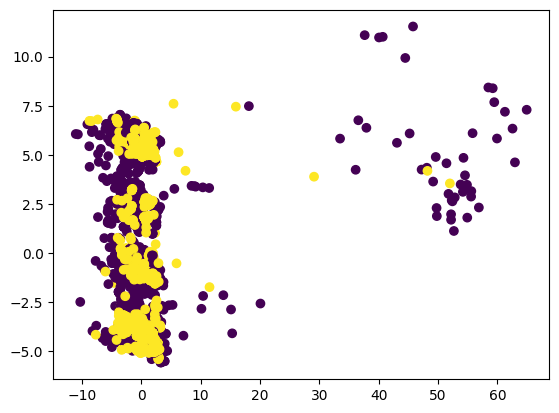

In [13]:
x_after_pca_in_2D = pca.fit_transform(ss.fit_transform(df[features_list].to_numpy()))
plt.scatter(x_after_pca_in_2D[:, 0], x_after_pca_in_2D[:, 1], c=df['marker'].map({0: 0, 1: 1}))

In [14]:
def plot_feature_importance(model):
    plt.figure(figsize=(25, 25))
    plt.title("Feature importances")
    plt.barh(range(X_train.shape[1]), model.feature_importances_, align="center")
    plt.yticks(np.arange(X_train.shape[1]), features_list)
    plt.ylim([-1,X_train.shape[1]])
    plt.show()

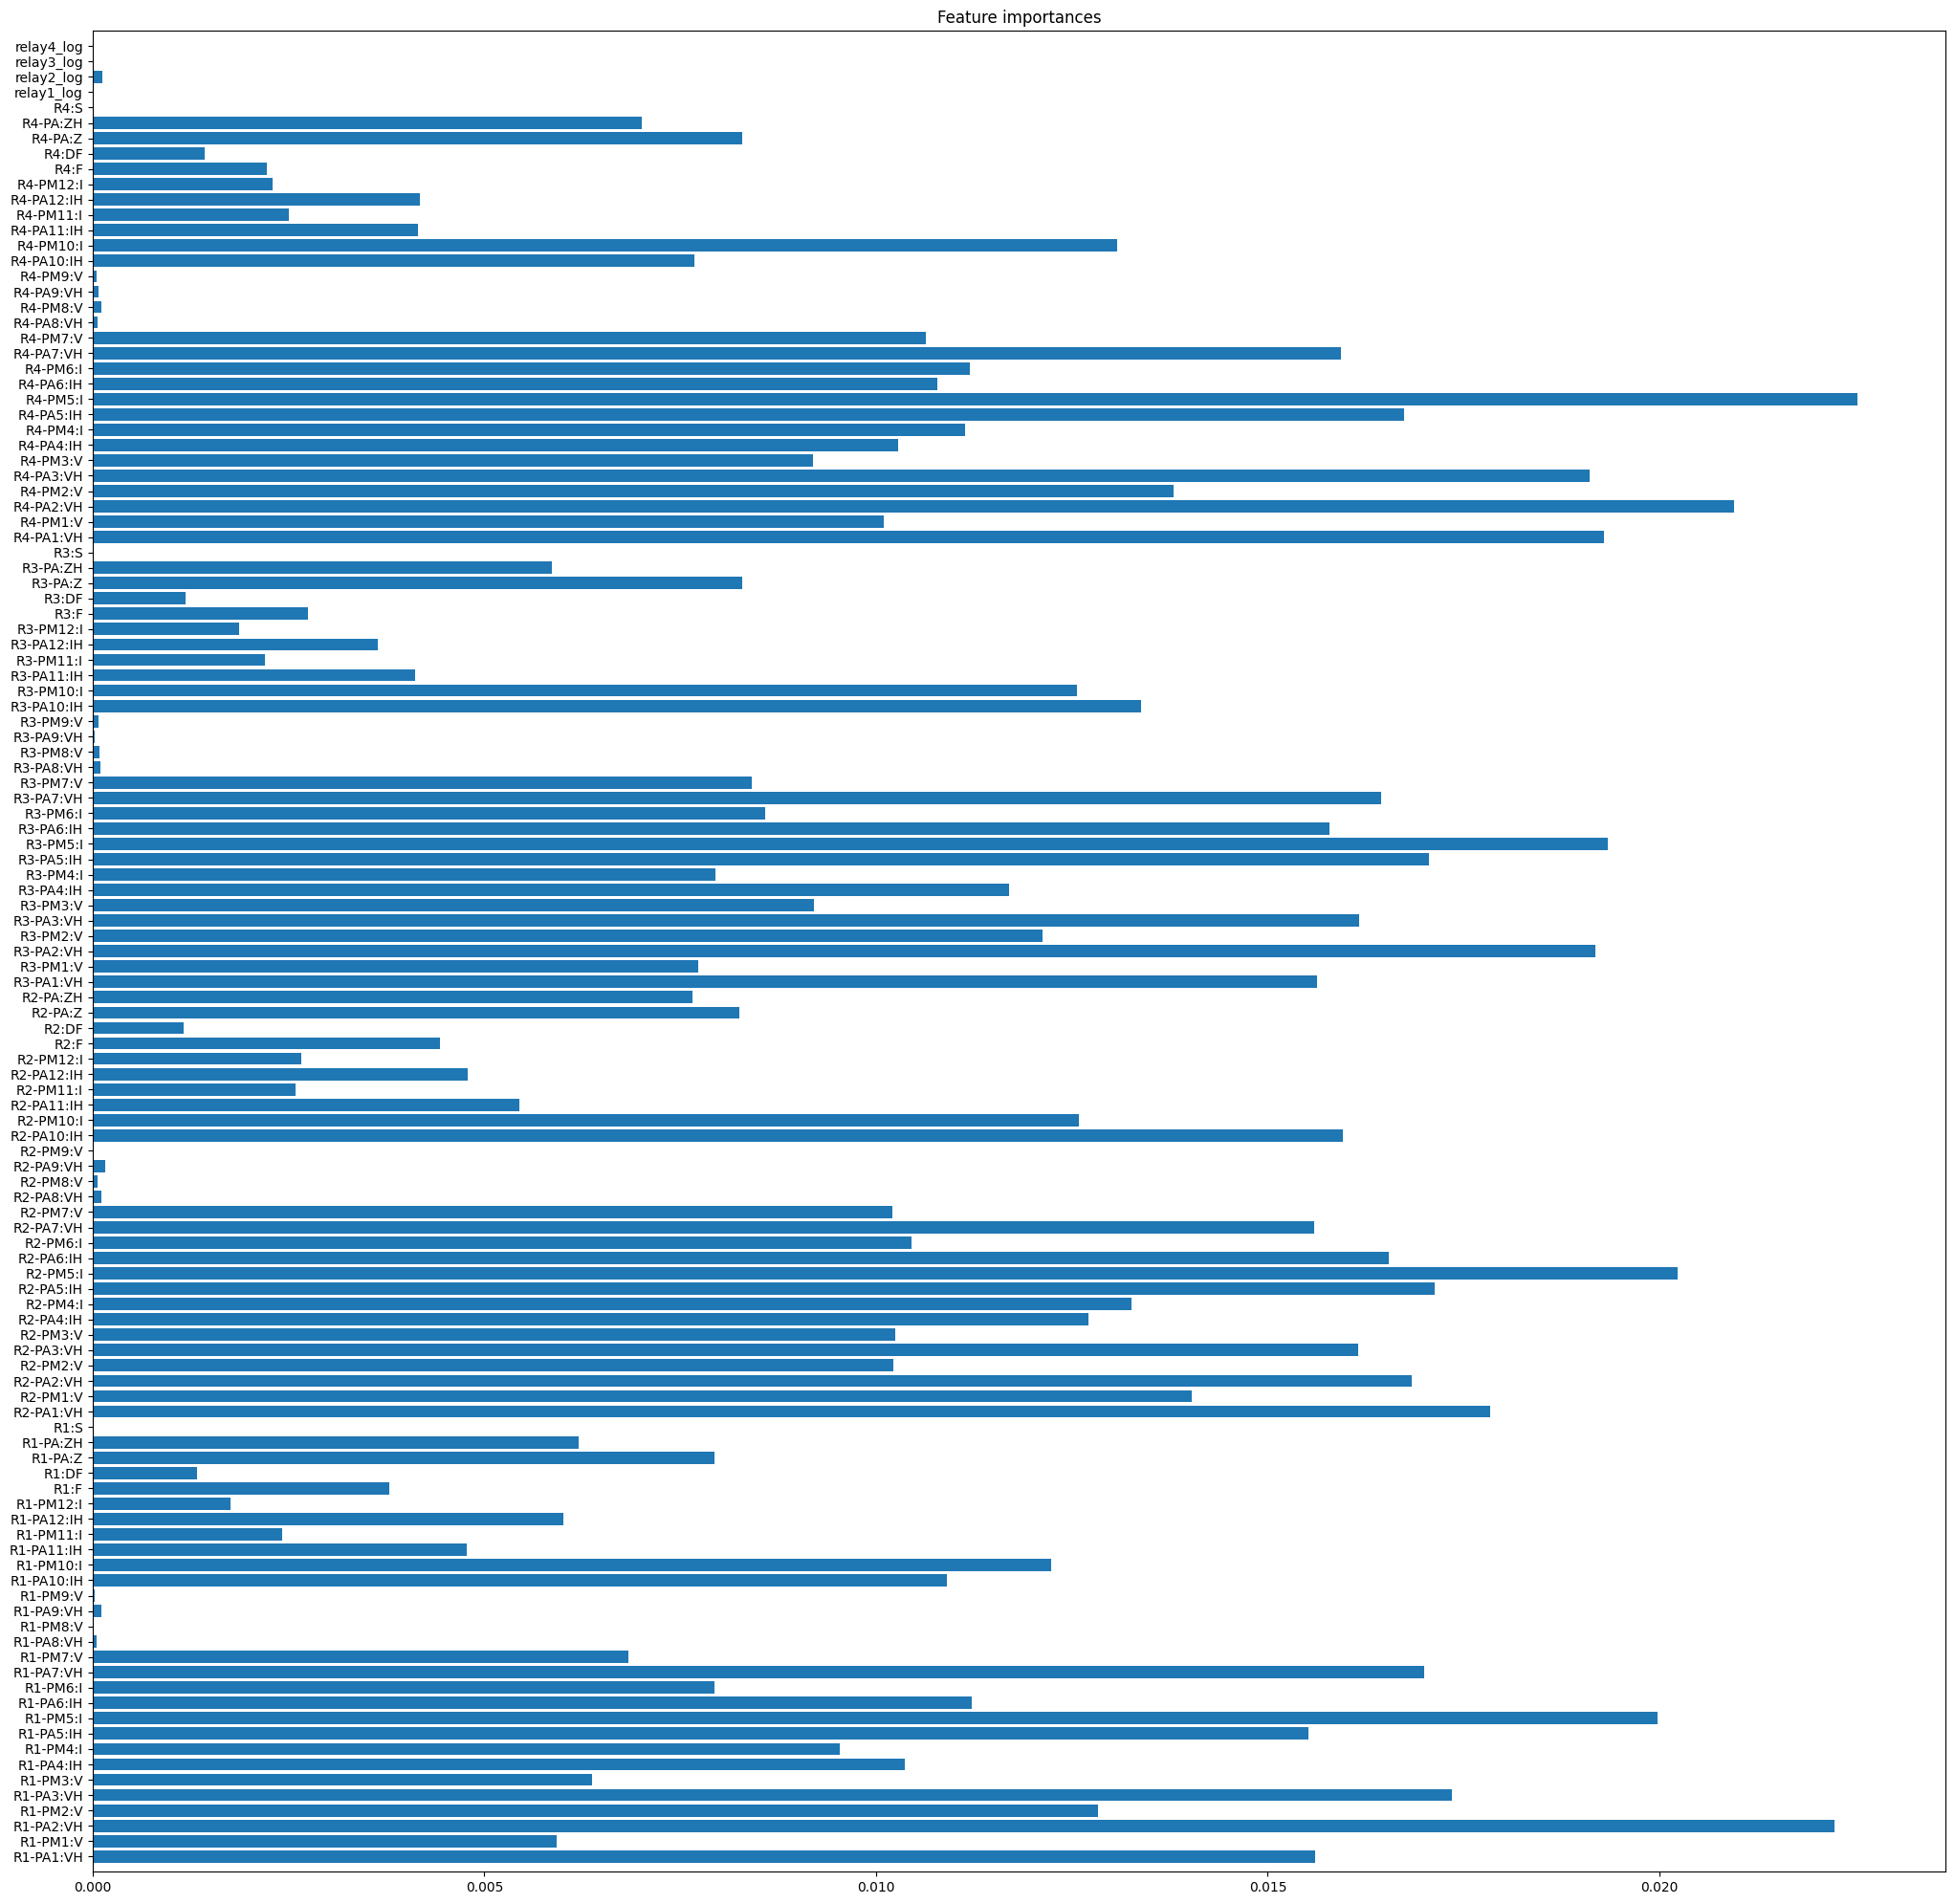

In [15]:
# Feature selection with Random Forest Classifier
rfc_fs = RandomForestClassifier(n_estimators=100, random_state=42)
rfc_fs.fit(X_train, y_train)
plot_feature_importance(rfc_fs)

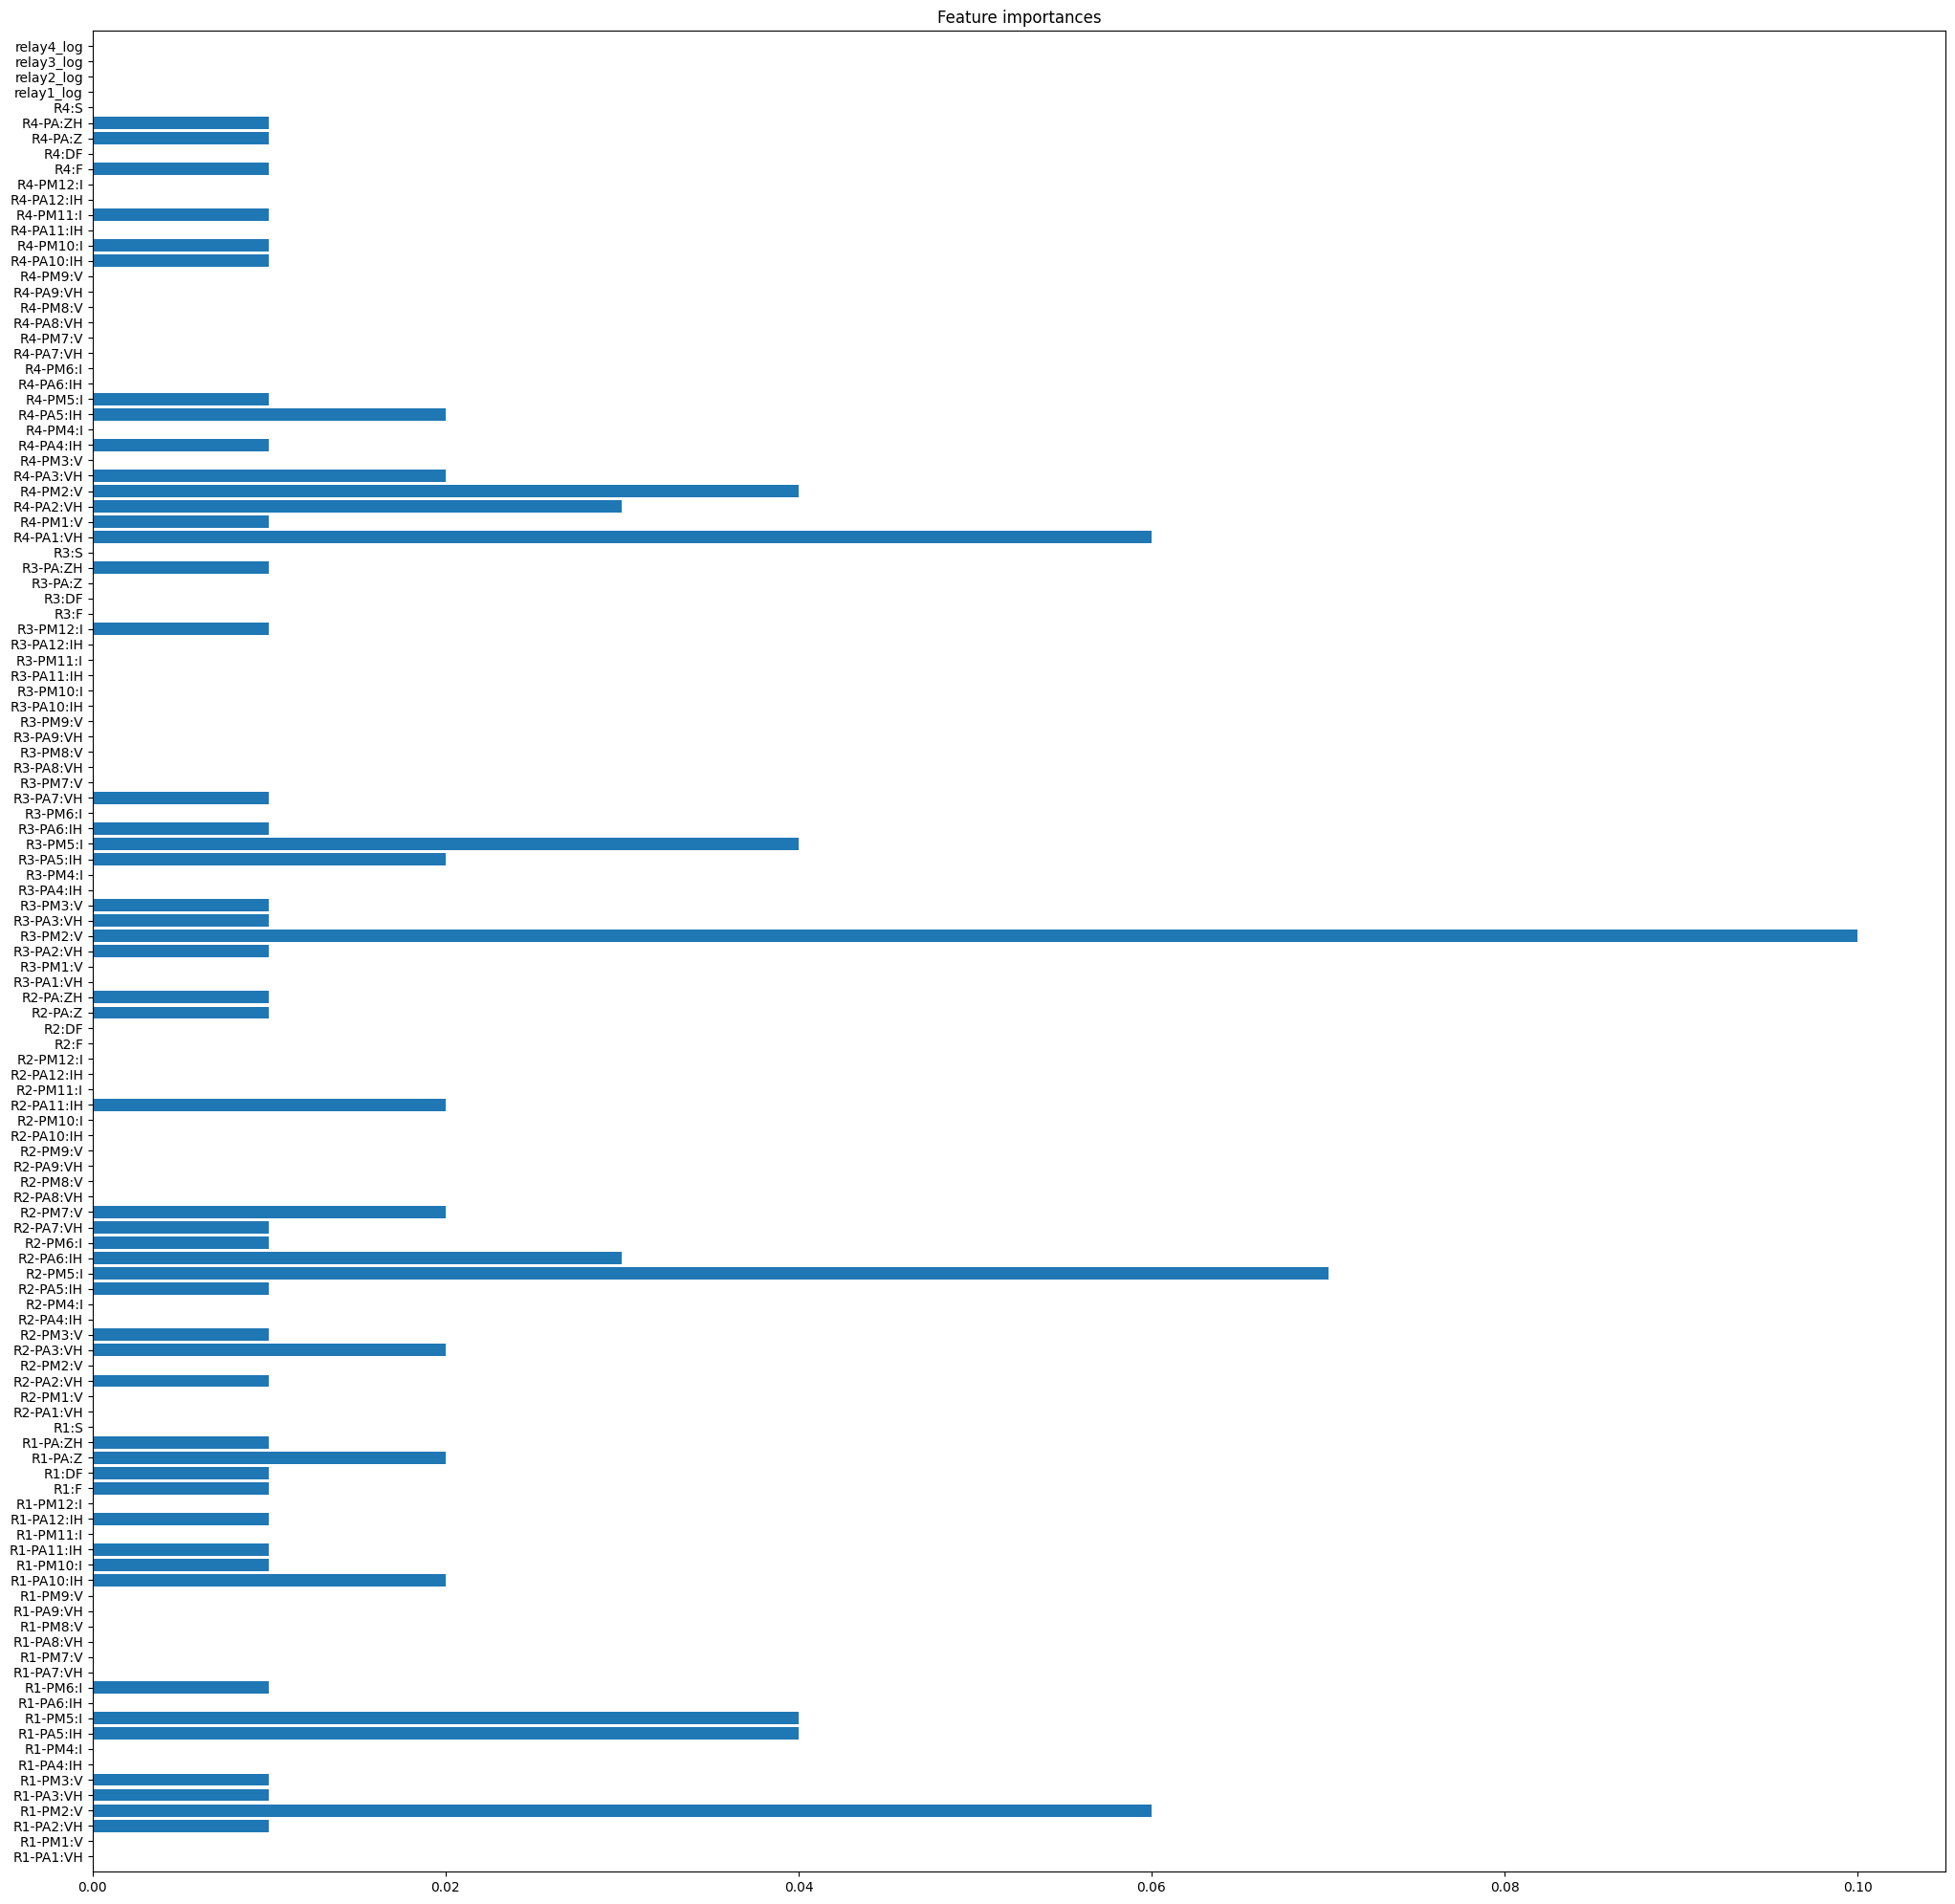

In [16]:
# Feature selection with AdaBoost Classifier
abc_fs = AdaBoostClassifier(n_estimators=100, random_state=42)
abc_fs.fit(X_train, y_train)
plot_feature_importance(abc_fs)

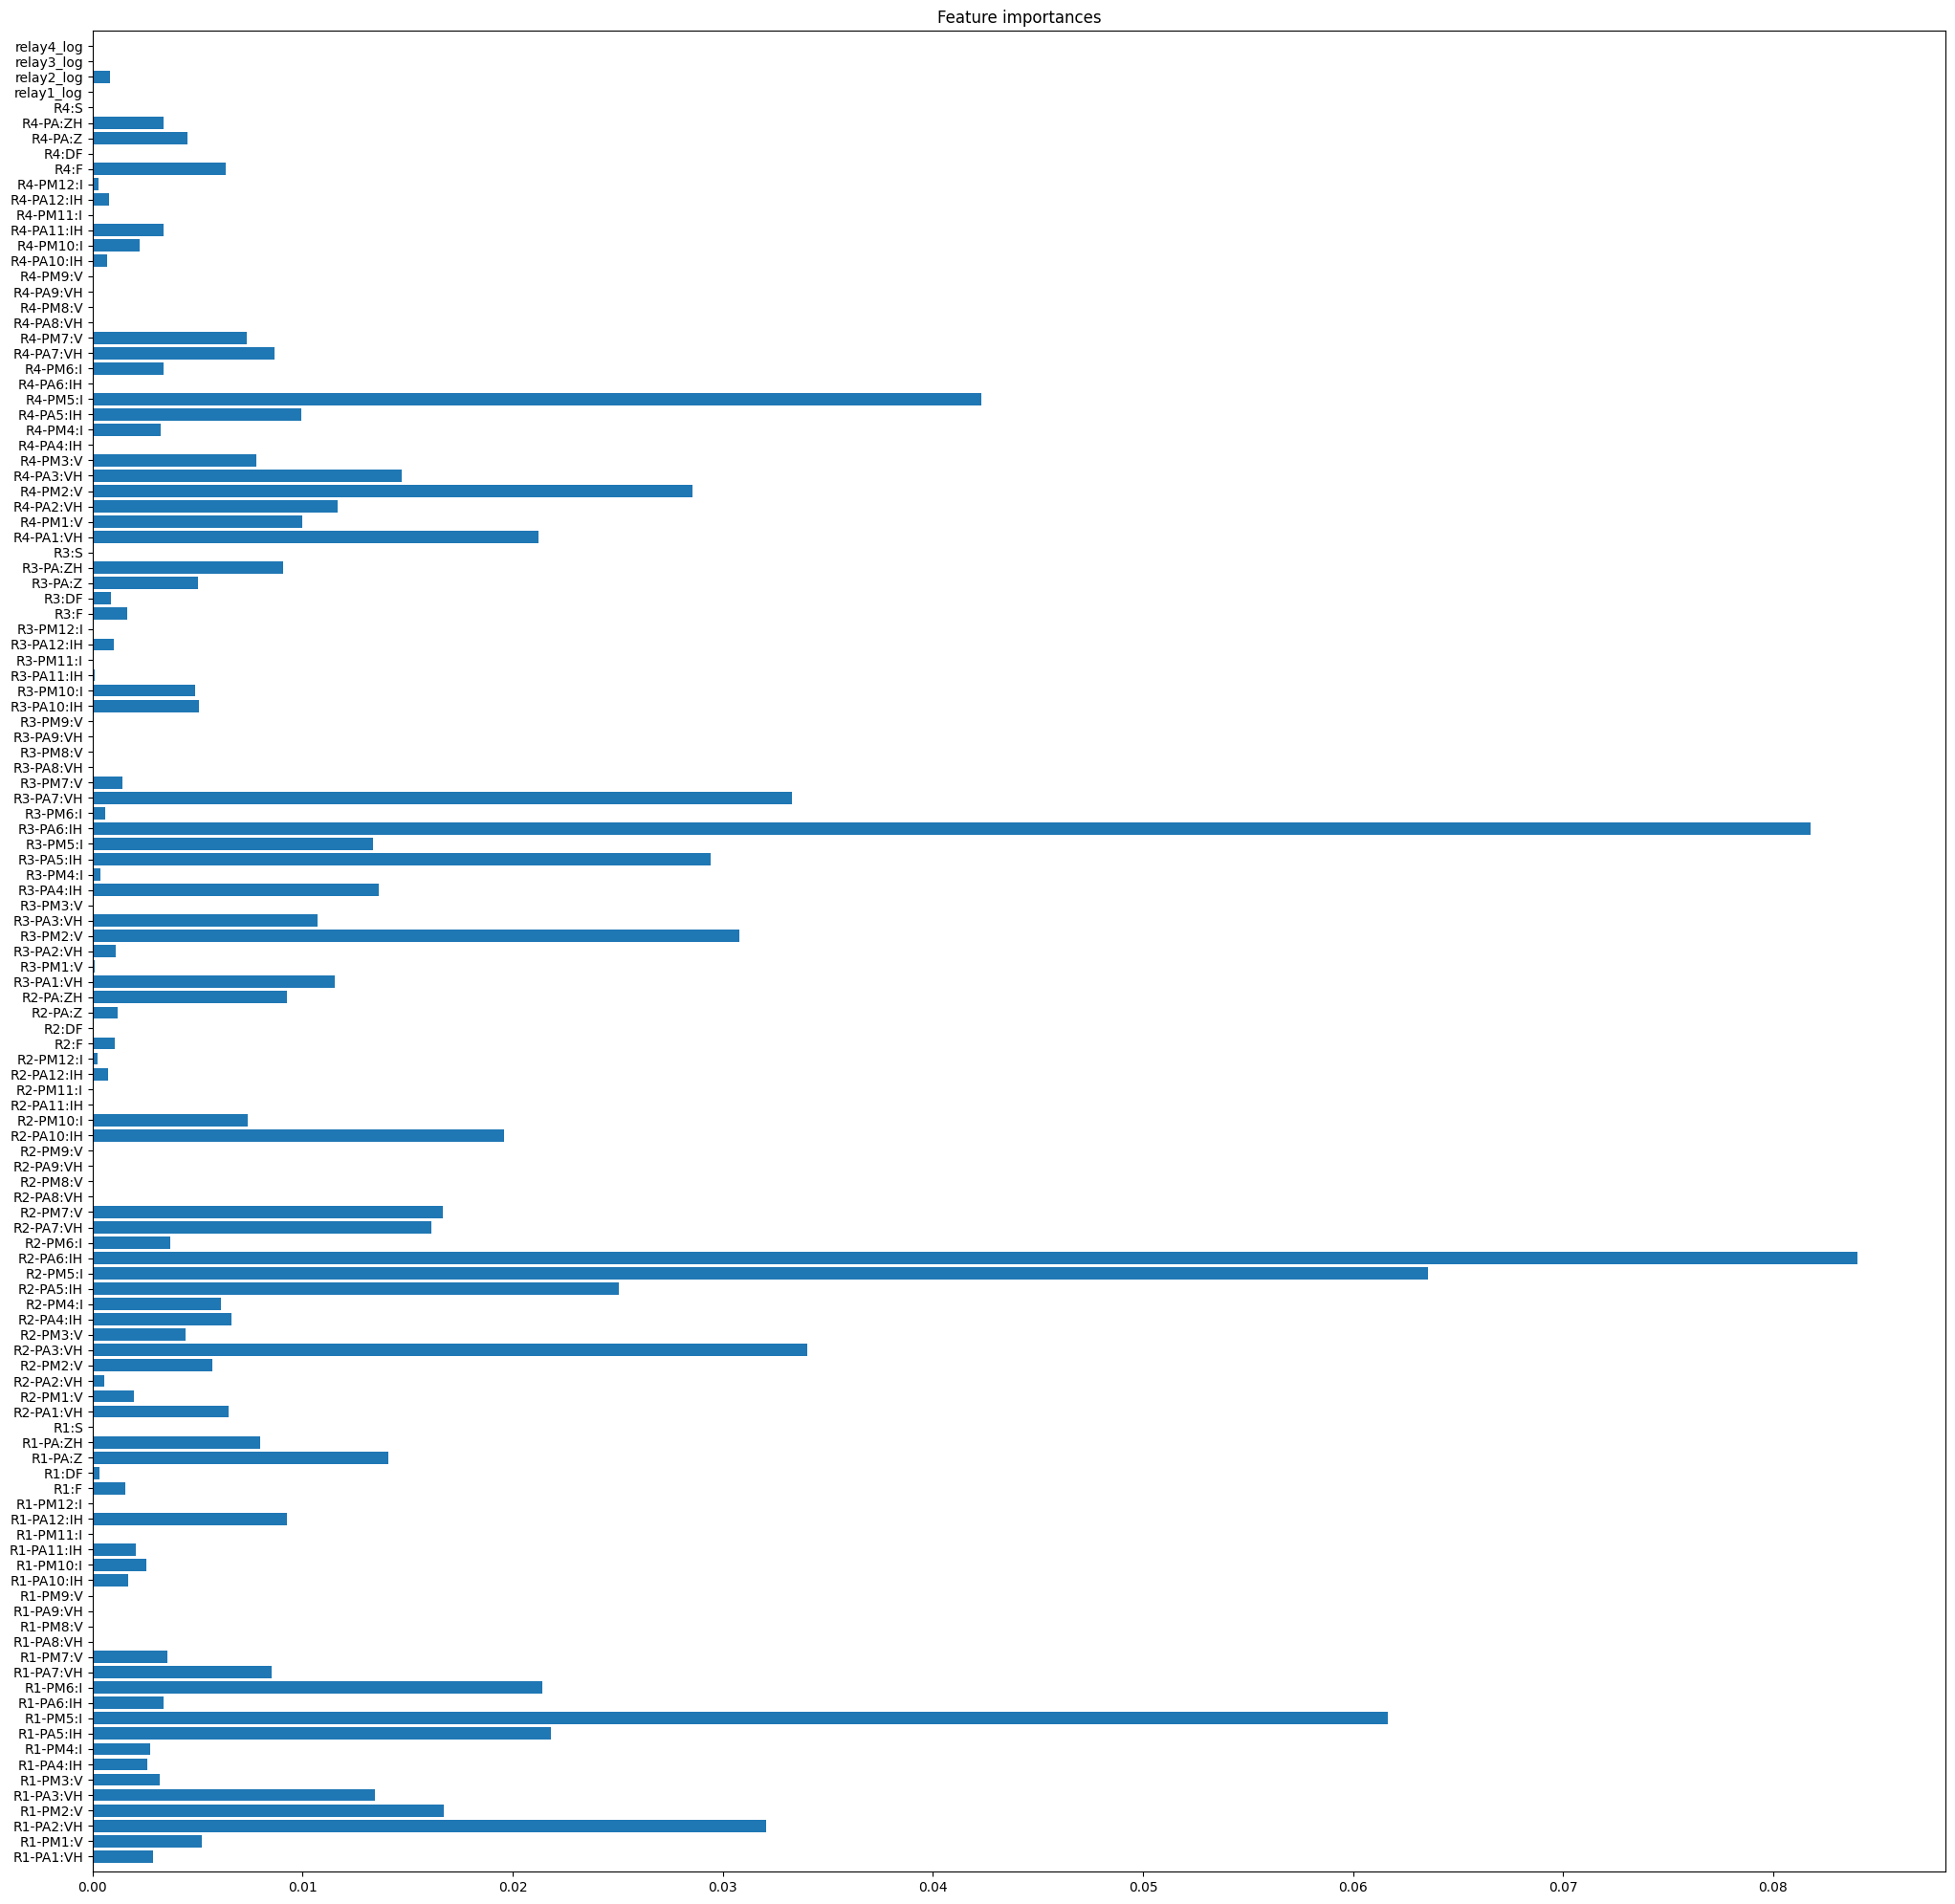

In [17]:
# Feature selection with Gradient Boosting Classifier
gbc_fs = GradientBoostingClassifier(n_estimators=100, random_state=42)
gbc_fs.fit(X_train, y_train)
plot_feature_importance(gbc_fs)

/home/nonofurbuisness/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



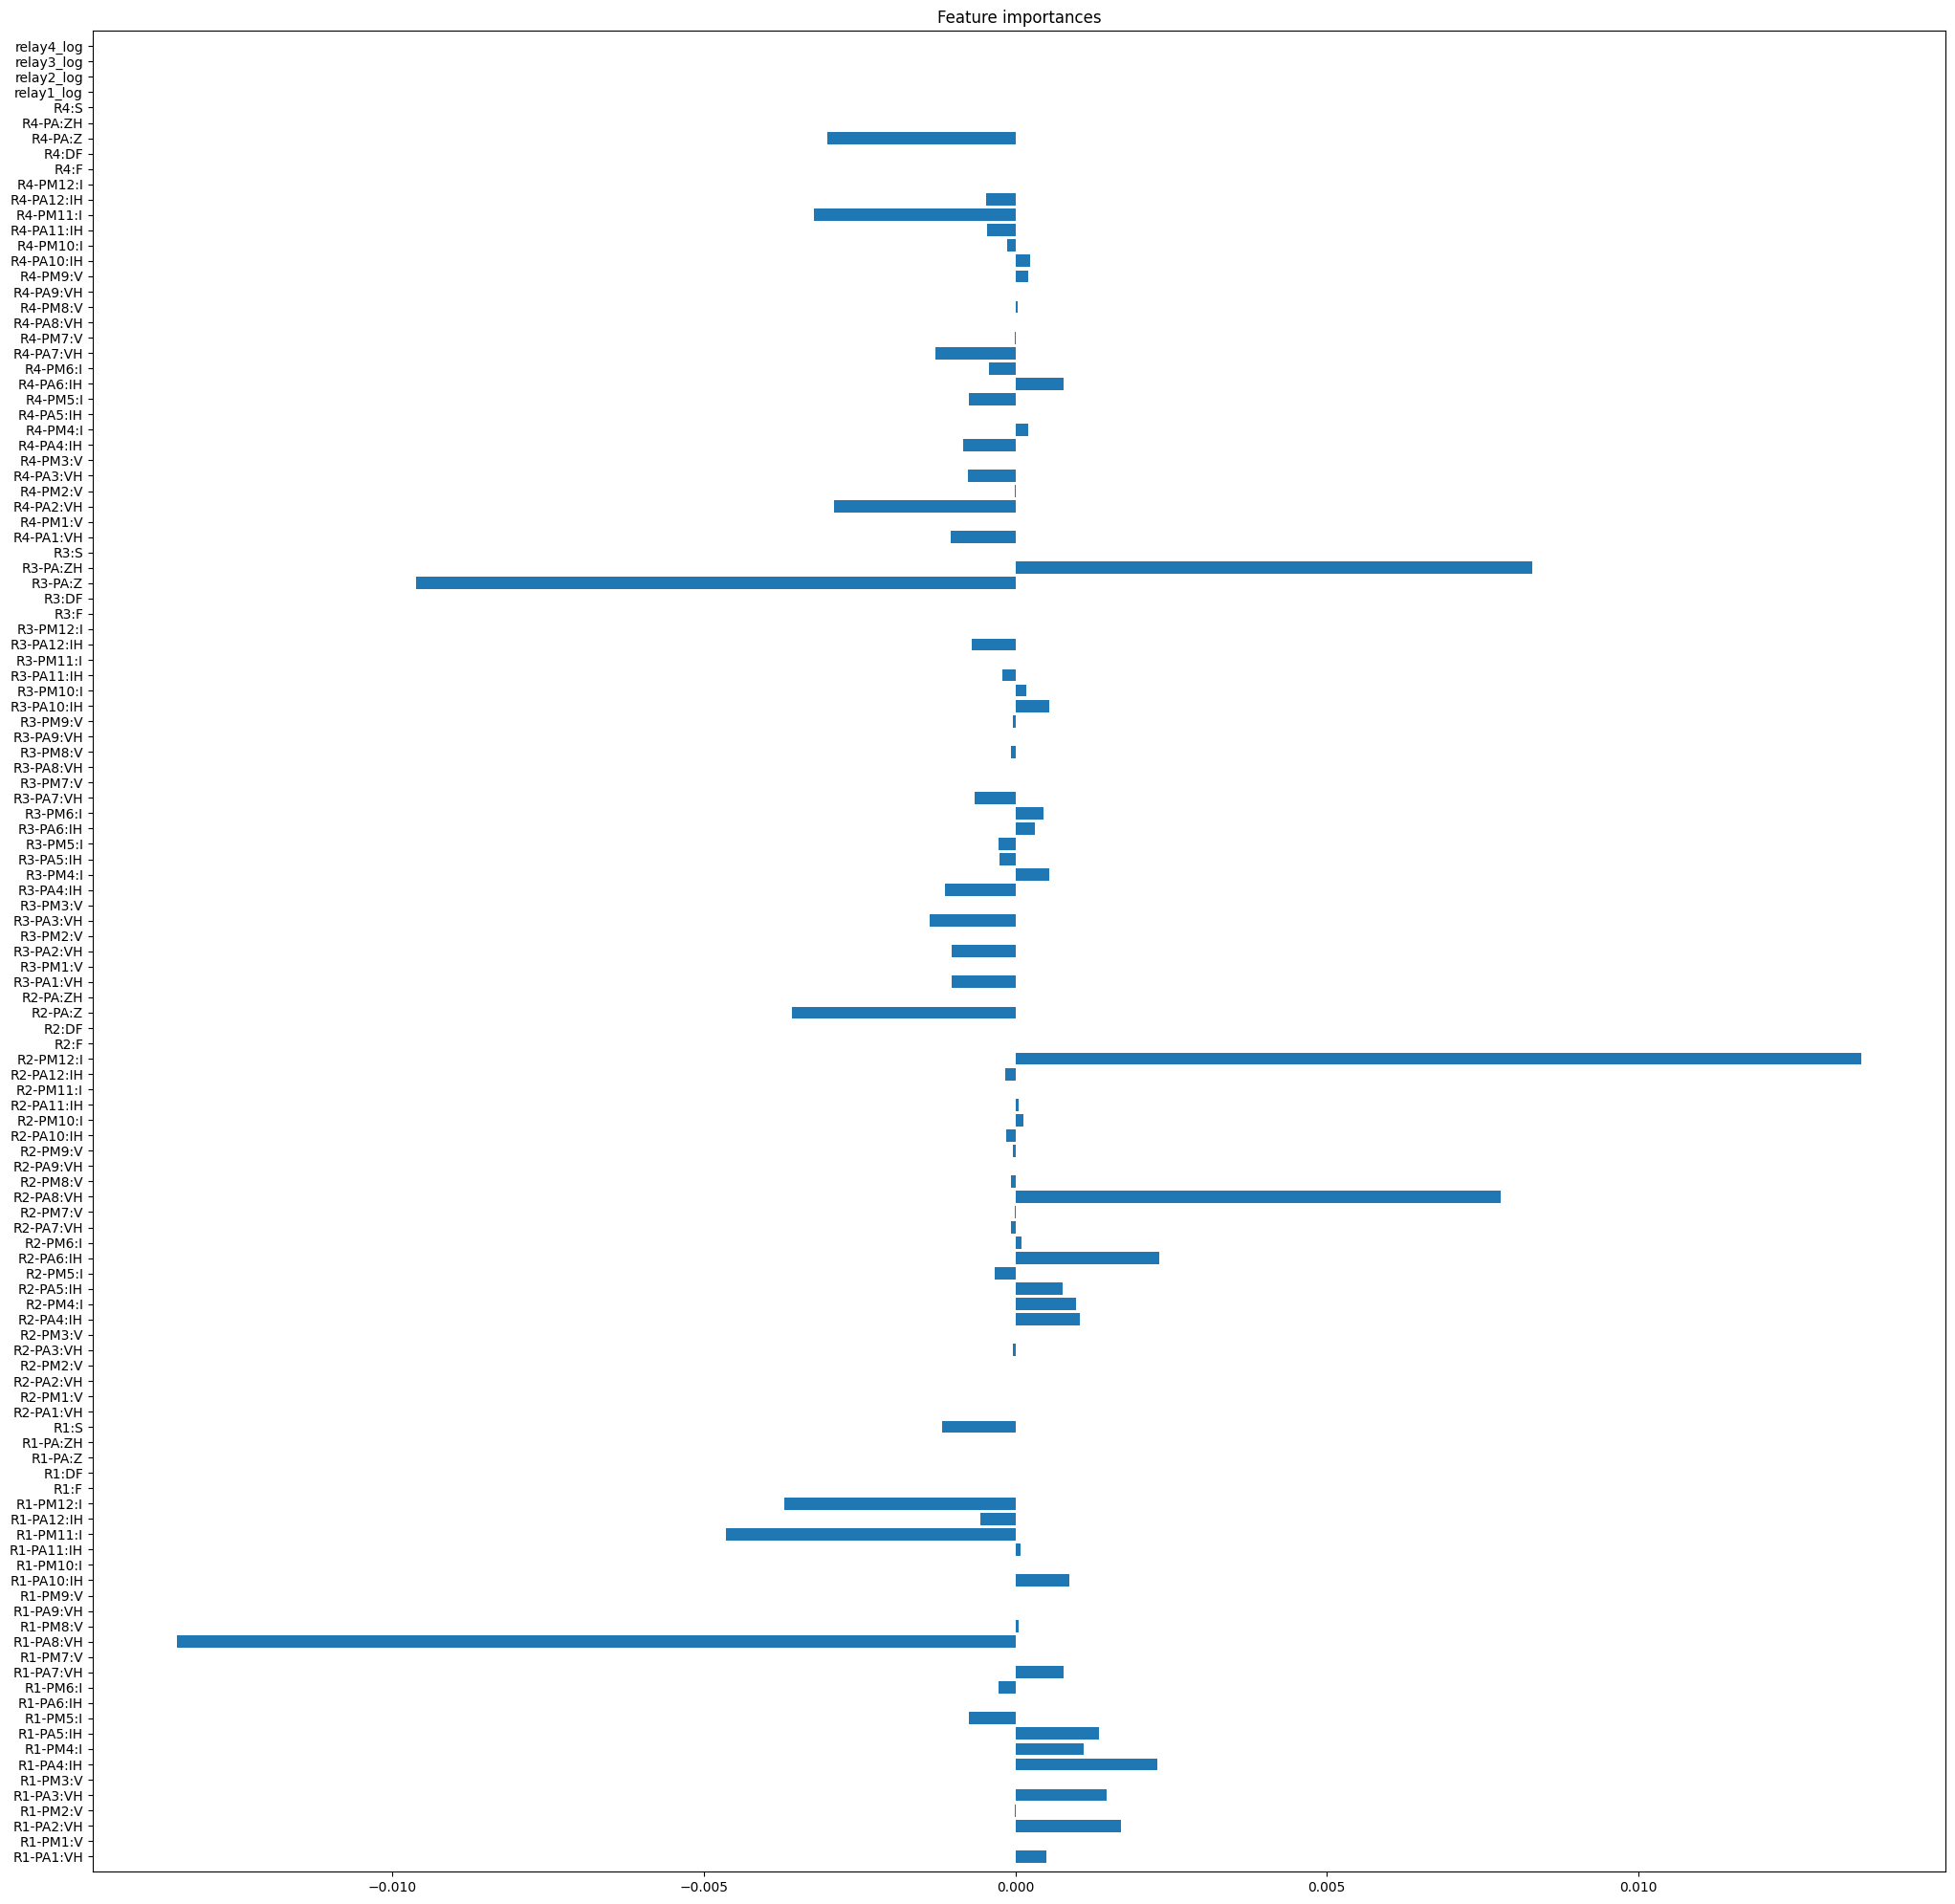

In [18]:
# Feature importance with Linear SVC
from sklearn.svm import LinearSVC
lsvc_fs = LinearSVC(C=0.01, penalty="l1", dual=False).fit(X_train, y_train)
lsvc_fs.coef_

# Plot feature importance with Linear SVC
plt.figure(figsize=(25, 25))
plt.title("Feature importances")
plt.barh(range(X_train.shape[1]), lsvc_fs.coef_[0], align="center")
plt.yticks(np.arange(X_train.shape[1]), features_list)
plt.ylim([-1, X_train.shape[1]])
plt.show()

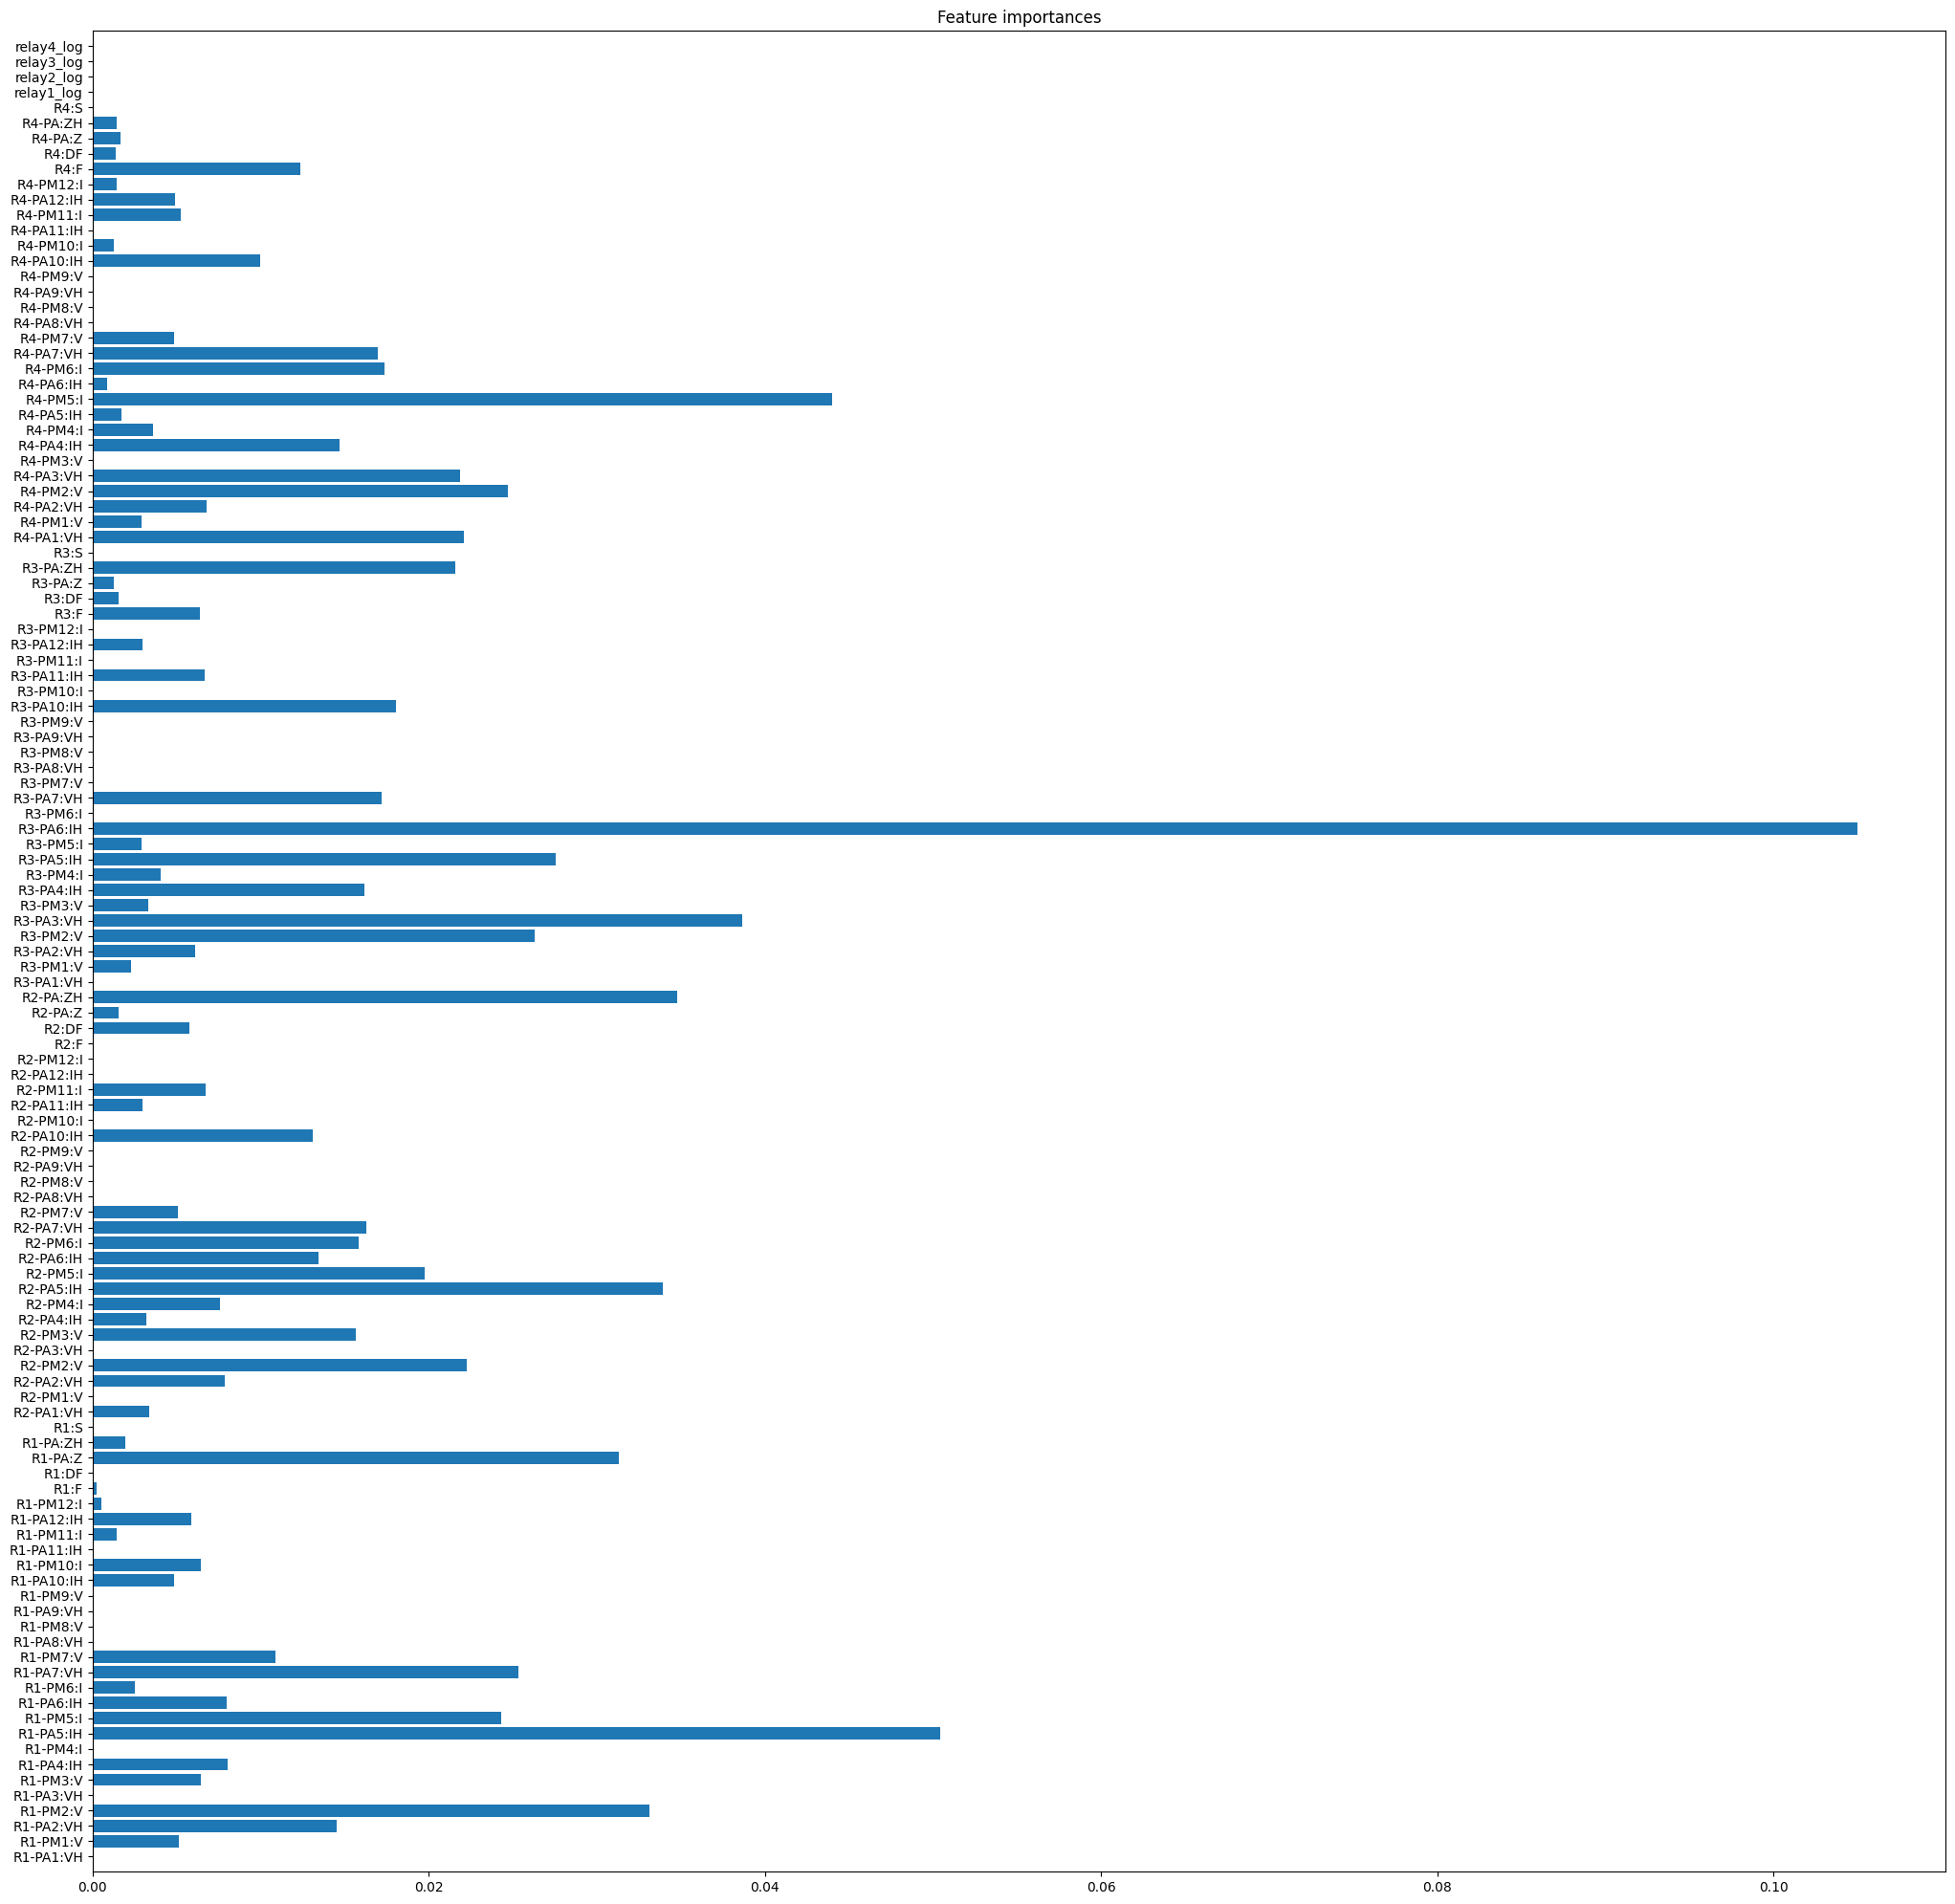

In [19]:
# Feature selection with Decision Tree Classifier
dtc_fs = DecisionTreeClassifier(random_state=42)
dtc_fs.fit(X_train, y_train)
plot_feature_importance(dtc_fs)

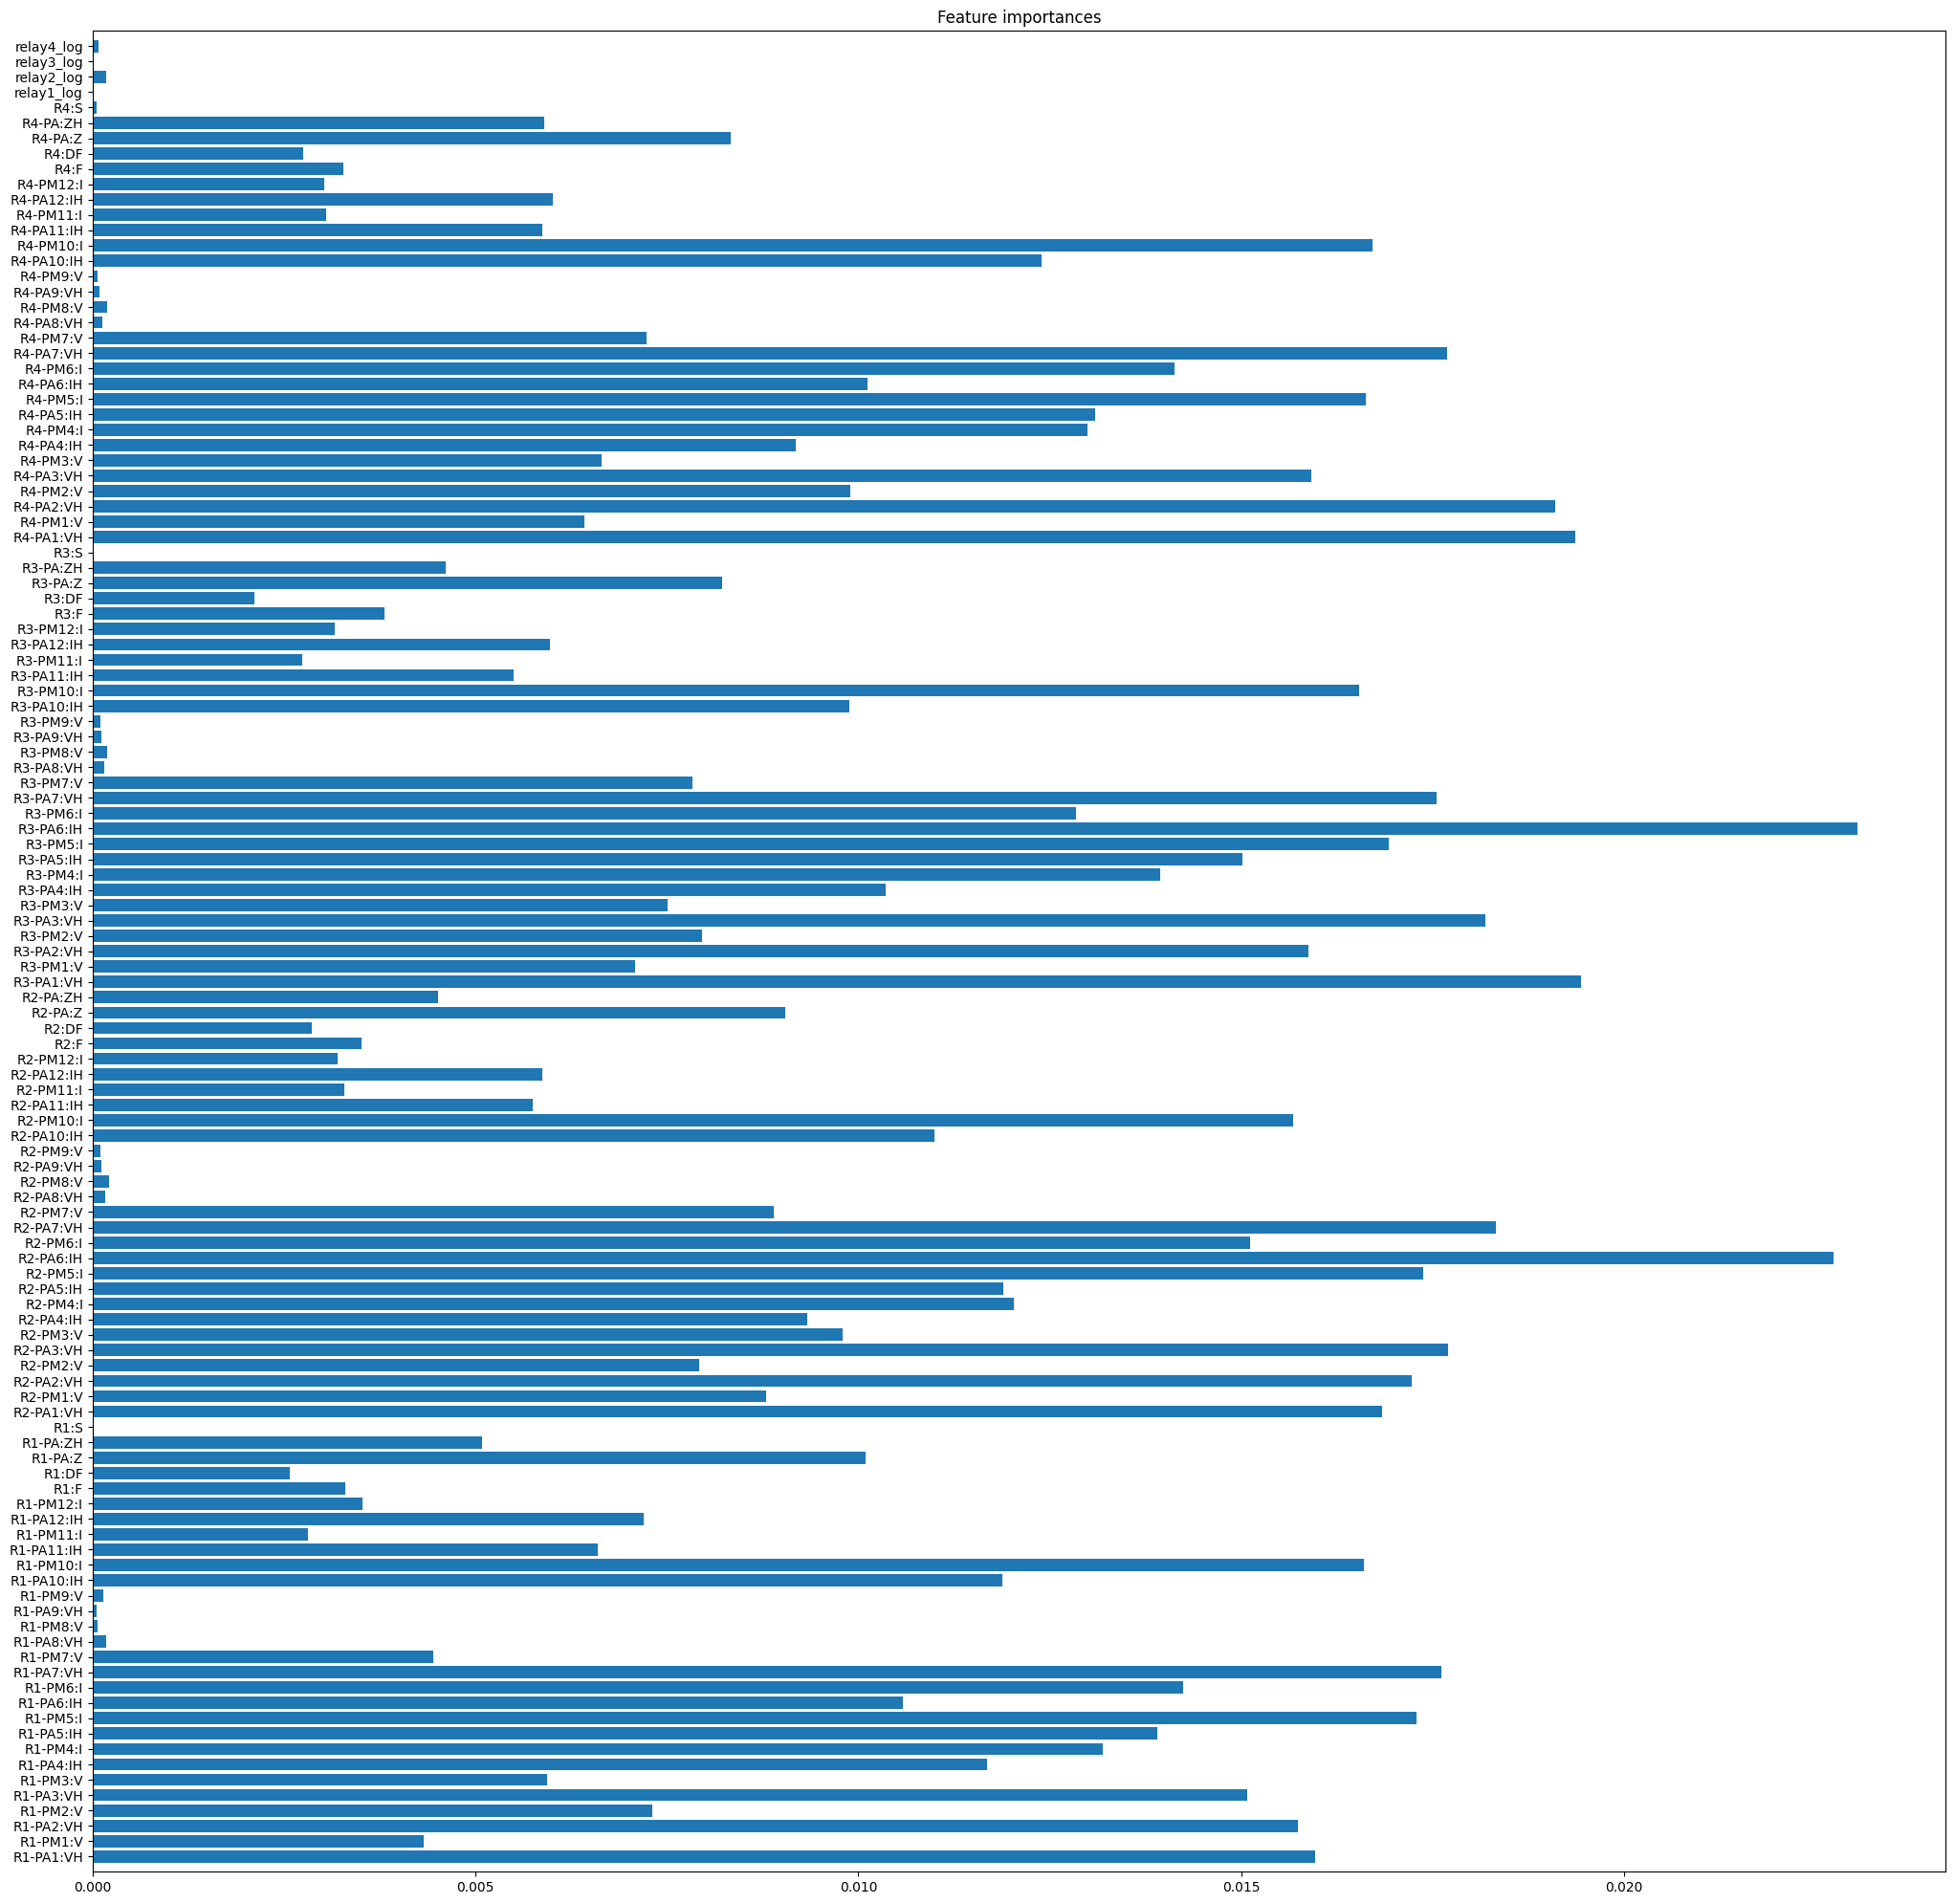

In [20]:
# Feature selection with Extra Trees Classifier
etc_fs = ExtraTreesClassifier(n_estimators=100, random_state=42)
etc_fs.fit(X_train, y_train)
plot_feature_importance(etc_fs)

In [21]:
# Print the feature ranking - Top 10
fs_table = pd.DataFrame(columns=['Feature', 'Random Forest', 'AdaBoost', 'Gradient Boosting', 'Linear SVC', 'Decision Tree', 'Extra Trees'])
fs_table['Feature'] = features_list
fs_table['Random Forest'] = rfc_fs.feature_importances_

fs_table['AdaBoost'] = abc_fs.feature_importances_
fs_table['Gradient Boosting'] = gbc_fs.feature_importances_
fs_table['Linear SVC'] = np.abs(lsvc_fs.coef_[0])
fs_table['Decision Tree'] = dtc_fs.feature_importances_
fs_table['Extra Trees'] = etc_fs.feature_importances_

fs_table['Mean'] = fs_table.mean(axis=1)
fs_table.sort_values(by='Mean', ascending=False, inplace=True)
fs_table.head(15)

/tmp/ipykernel_23120/238635405.py:12: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



,Feature,Random Forest,AdaBoost,Gradient Boosting,Linear SVC,Decision Tree,Extra Trees,Mean
67,R3-PA6:IH,0.015787,0.01,0.081759,0.000312,0.104987,0.023050,0.039316
38,R2-PM5:I,0.020227,0.07,0.063591,0.000329,0.019725,0.017384,0.031876
60,R3-PM2:V,0.012122,0.10,0.030776,0.000004,0.026287,0.007963,0.029525
39,R2-PA6:IH,0.016548,0.03,0.084017,0.002308,0.013456,0.022742,0.028179
9,R1-PM5:I,0.019974,0.04,0.061674,0.000754,0.024327,0.017284,0.027335
86,R4-PA1:VH,0.019294,0.06,0.021206,0.001040,0.022106,0.019369,0.023836
8,R1-PA5:IH,0.015522,0.04,0.021823,0.001336,0.050405,0.013904,0.023832
95,R4-PM5:I,0.022528,0.01,0.042317,0.000748,0.043963,0.016634,0.022698
3,R1-PM2:V,0.012836,0.06,0.016714,0.000002,0.033147,0.007315,0.021669
89,R4-PM2:V,0.013798,0.04,0.028550,0.000003,0.024675,0.009899,0.019487


In [22]:
pca = PCA()
pca.fit(ss.fit_transform(df[features_list].to_numpy()))

exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)

px.area(
    x=range(1, exp_var_cumul.shape[0] + 1),
    y=exp_var_cumul,
    labels={"x": "# Components", "y": "Explained Variance"},
    range_y=(0.98, 1.02),
    title="SVD Explained Variance Ratio"
)

Fitting estimator with 119 features.
Fitting estimator with 119 features.
Fitting estimator with 118 features.
Fitting estimator with 118 features.
Fitting estimator with 117 features.
Fitting estimator with 117 features.
Fitting estimator with 116 features.
Fitting estimator with 116 features.
Fitting estimator with 115 features.
Fitting estimator with 115 features.
Fitting estimator with 114 features.
Fitting estimator with 114 features.
Fitting estimator with 113 features.
Fitting estimator with 113 features.
Fitting estimator with 112 features.
Fitting estimator with 112 features.
Fitting estimator with 111 features.
Fitting estimator with 111 features.
Fitting estimator with 110 features.
Fitting estimator with 110 features.
Fitting estimator with 109 features.
Fitting estimator with 109 features.
Fitting estimator with 108 features.
Fitting estimator with 108 features.
Fitting estimator with 107 features.
Fitting estimator with 107 features.
Fitting estimator with 106 features.
F

/home/nonofurbuisness/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:103: FutureWarning:

The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.



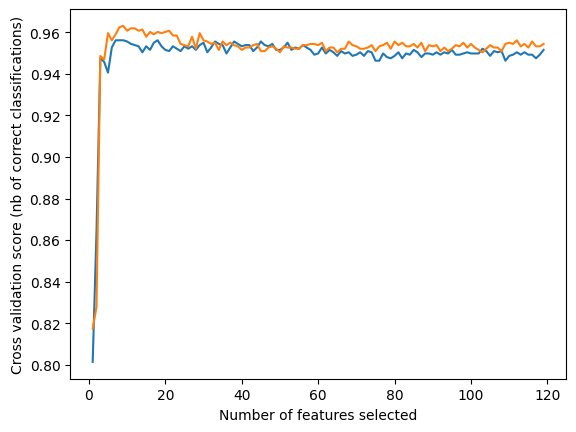

In [23]:
# Feature selection

from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

# Create the RFE object and compute a cross-validated score.
# The "accuracy" scoring is proportional to the number of correct classifications
recall_scorer = make_scorer(recall_score, pos_label=1, average='macro')
rfecv = RFECV(estimator=RandomForestClassifier(n_estimators=750,criterion= "entropy",max_depth= 20, min_samples_split= 2, random_state=43), step=1, cv=StratifiedKFold(2), scoring='accuracy', verbose=1, n_jobs=-1)
#rfecv = RFECV(estimator=LogisticRegression(), step=1, cv=StratifiedKFold(2), scoring='accuracy', verbose=1, n_jobs=-1)
rfecv.fit(X_train, y_train)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

X_train = rfecv.transform(X_train)
X_test = rfecv.transform(X_test)

In [24]:
# Print the optimal features
optimal_features = []
for i in range(len(rfecv.support_)):
    if rfecv.support_[i]:
        optimal_features.append(features_list[i])
print("Optimal features: "+ str(optimal_features))

Optimal features: ['R1-PA2:VH', 'R1-PM5:I', 'R2-PM5:I', 'R2-PA7:VH', 'R3-PA3:VH', 'R3-PA6:IH', 'R3-PA7:VH', 'R4-PA2:VH', 'R4-PM5:I']


In [25]:
def create_grid_search(model, params):
    # Create a grid search object which is used to find the best hyperparameters for the model
    from sklearn.model_selection import GridSearchCV
    return GridSearchCV(estimator=model, param_grid=params, n_jobs=-1, verbose=3, cv=3, scoring='accuracy', return_train_score=True)

In [26]:
def show(model):
    # We print our results
    sns.set(rc={'figure.figsize': (15, 8)})
    predictions = model.predict(X_test)
    true_labels = y_test
    cf_matrix = confusion_matrix(true_labels, predictions)
    model_report = classification_report(true_labels, predictions, digits=5)
    heatmap = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=np.unique(true_labels), yticklabels=np.unique(true_labels))

    # The heatmap is cool but this is the most important result
    print(model_report)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV 1/3] END criterion=gini, max_depth=20, min_samples_split=2, n_estimators=150, random_state=43;, score=(train=1.000, test=0.964) total time=   0.9s
[CV 2/3] END criterion=gini, max_depth=20, min_samples_split=2, n_estimators=150, random_state=43;, score=(train=1.000, test=0.964) total time=   1.0s
[CV 3/3] END criterion=gini, max_depth=20, min_samples_split=2, n_estimators=150, random_state=43;, score=(train=1.000, test=0.964) total time=   1.0s
[CV 1/3] END criterion=gini, max_depth=20, min_samples_split=2, n_estimators=250, random_state=43;, score=(train=1.000, test=0.964) total time=   1.5s
[CV 2/3] END criterion=gini, max_depth=20, min_samples_split=2, n_estimators=250, random_state=43;, score=(train=1.000, test=0.964) total time=   1.4s
[CV 3/3] END criterion=gini, max_depth=20, min_samples_split=2, n_estimators=250, random_state=43;, score=(train=1.000, test=0.965) total time=   1.5s
[CV 1/3] END criterion=entropy, ma

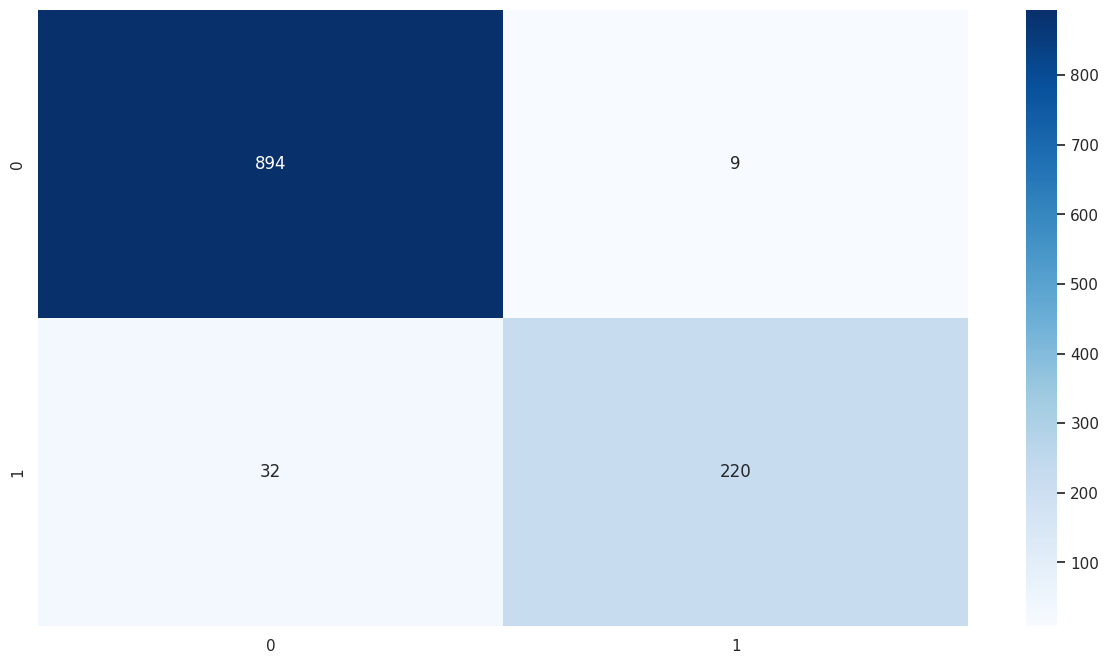

In [27]:
# Random Forest Classifier
rf = RandomForestClassifier()
rf_params = {
    "n_estimators": [150, 250, 750],
    "criterion": ["gini", "entropy"],
    "max_depth": [20],
    "min_samples_split": [2],
    "random_state": [43],
}
rf_grid = create_grid_search(rf, rf_params)
rf_grid.fit(X_train, y_train)
rf = rf_grid.best_estimator_
pickle.dump(rf, open('m1_rfc_grid.pkl', 'wb'))
show(rf)

In [28]:
print(rf_grid.best_params_)

{'criterion': 'entropy', 'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 150, 'random_state': 43}


Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV 3/3] END learning_rate=0.1, n_estimators=50;, score=(train=1.000, test=0.966) total time=   1.3s
[CV 1/3] END learning_rate=0.1, n_estimators=50;, score=(train=1.000, test=0.963) total time=   1.4s
[CV 2/3] END learning_rate=0.1, n_estimators=50;, score=(train=1.000, test=0.965) total time=   1.5s
[CV 1/3] END learning_rate=0.1, n_estimators=100;, score=(train=1.000, test=0.966) total time=   1.6s
[CV 2/3] END learning_rate=0.1, n_estimators=100;, score=(train=1.000, test=0.963) total time=   1.2s
[CV 3/3] END learning_rate=0.1, n_estimators=100;, score=(train=1.000, test=0.964) total time=   1.2s
[CV 1/3] END learning_rate=0.1, n_estimators=150;, score=(train=1.000, test=0.966) total time=   1.4s
[CV 2/3] END learning_rate=0.1, n_estimators=150;, score=(train=1.000, test=0.964) total time=   1.3s
[CV 3/3] END learning_rate=0.1, n_estimators=150;, score=(train=1.000, test=0.966) total time=   1.2s
[CV 1/3] END learning_

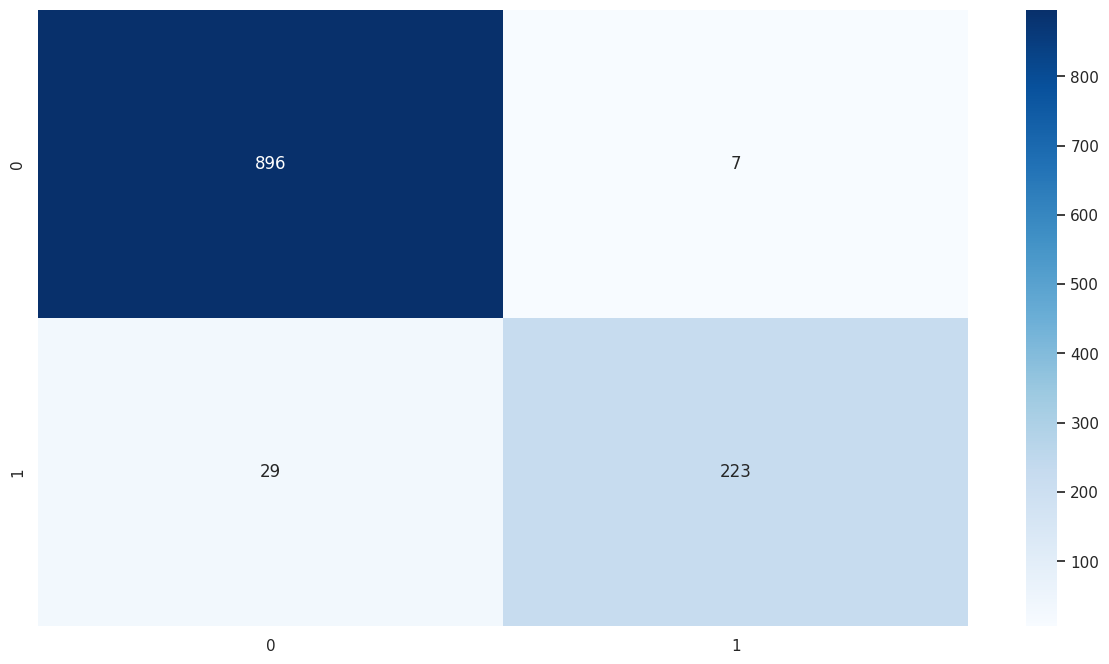

In [29]:
# Random Forest Classifier + AdaBoost
rf_ada = AdaBoostClassifier(base_estimator=rf)
rf_ada_params = {
    'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400, 450, 500],
    'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
}
rf_ada_gcv = create_grid_search(rf_ada, rf_ada_params)
rf_ada_gcv.fit(X_train, y_train)

rf_ada = rf_ada_gcv.best_estimator_

# Save the model
pickle.dump(rf_ada, open('m1_rf_ada_gcv.pkl', 'wb'))

show(rf_ada)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 3/3] END algorithm=auto, leaf_size=10, n_neighbors=3, p=1, weights=distance;, score=(train=1.000, test=0.973) total time=   0.0s
[CV 2/3] END algorithm=auto, leaf_size=10, n_neighbors=3, p=1, weights=distance;, score=(train=1.000, test=0.971) total time=   0.0s
[CV 1/3] END algorithm=auto, leaf_size=10, n_neighbors=3, p=1, weights=distance;, score=(train=1.000, test=0.972) total time=   0.0s
              precision    recall  f1-score   support

           0    0.98134   0.99003   0.98567       903
           1    0.96311   0.93254   0.94758       252

    accuracy                        0.97749      1155
   macro avg    0.97223   0.96129   0.96662      1155
weighted avg    0.97736   0.97749   0.97736      1155



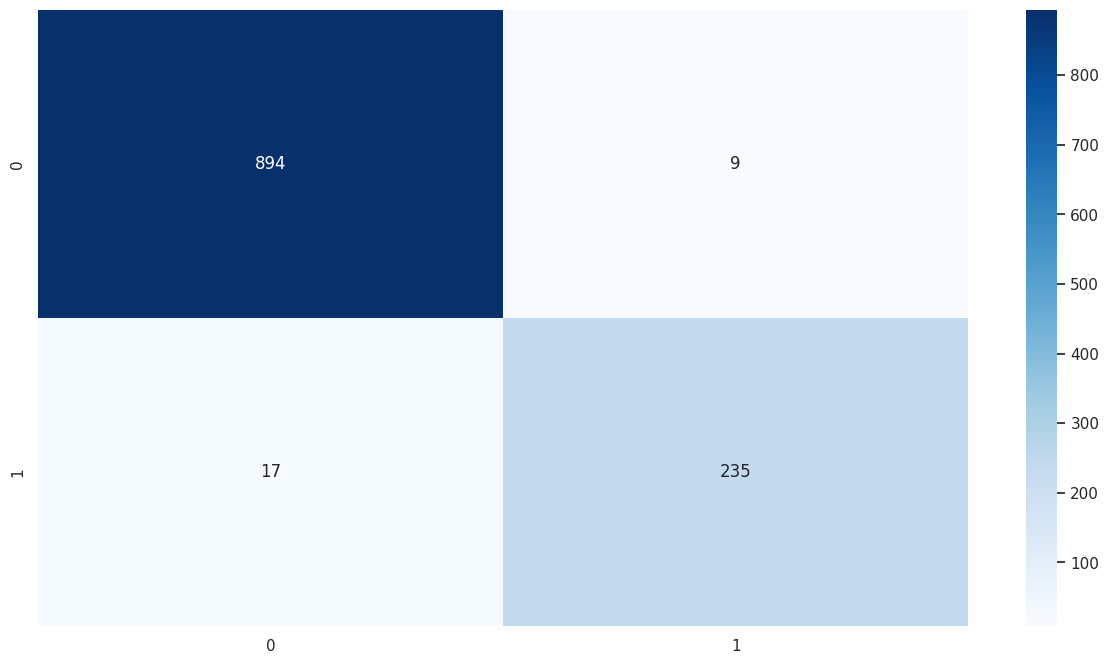

In [30]:
# K Nearest Neighbors
knn = KNeighborsClassifier()
knn_params = {
    "n_neighbors": [3],
    "weights": ["distance"],
    "algorithm": ["auto"],
    "leaf_size": [10],
    "p": [1]
}
knn_grid = create_grid_search(knn, knn_params)
knn_grid.fit(X_train, y_train)
knn = knn_grid.best_estimator_
pickle.dump(knn, open('m1_knn_grid.pkl', 'wb'))
show(knn)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 3/3] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 100, 100, 100, 100), learning_rate=adaptive, solver=adam;, score=(train=0.822, test=0.821) total time=   5.0s
[CV 2/3] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 100, 100, 100, 100), learning_rate=adaptive, solver=adam;, score=(train=0.825, test=0.814) total time=   6.0s
[CV 1/3] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 100, 100, 100, 100), learning_rate=adaptive, solver=adam;, score=(train=0.838, test=0.822) total time=   7.0s
              precision    recall  f1-score   support

           0    0.85700   0.92913   0.89160       903
           1    0.63636   0.44444   0.52336       252

    accuracy                        0.82338      1155
   macro avg    0.74668   0.68678   0.70748      1155
weighted avg    0.80886   0.82338   0.81126      1155



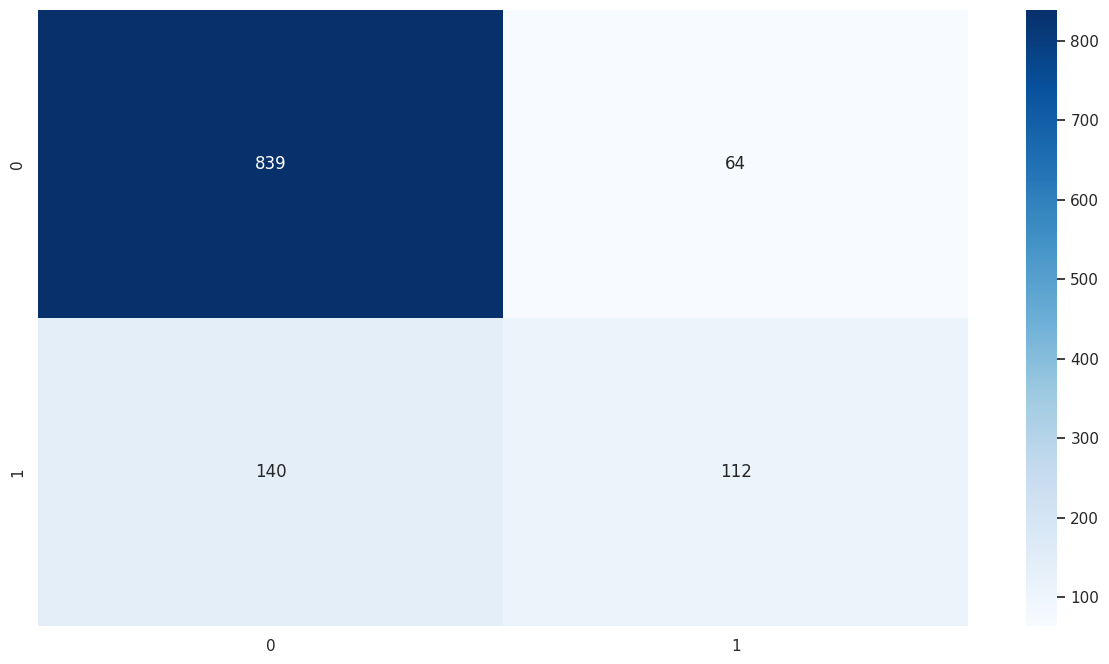

In [31]:
# Neural Network Classifier
nn = MLPClassifier()
nn_params = {
    "hidden_layer_sizes": [(100, 100, 100, 100, 100)],
    "activation": ["tanh"],
    "solver": ["adam"],
    "alpha": [0.01],
    "learning_rate": ["adaptive"],
}   
nn_grid = create_grid_search(nn, nn_params)
nn_grid.fit(X_train, y_train)
nn = nn_grid.best_estimator_
pickle.dump(nn, open('m1_nn_grid.pkl', 'wb'))
show(nn)

              precision    recall  f1-score   support

           0    0.98138   0.99225   0.98678       903
           1    0.97107   0.93254   0.95142       252

    accuracy                        0.97922      1155
   macro avg    0.97623   0.96239   0.96910      1155
weighted avg    0.97913   0.97922   0.97907      1155



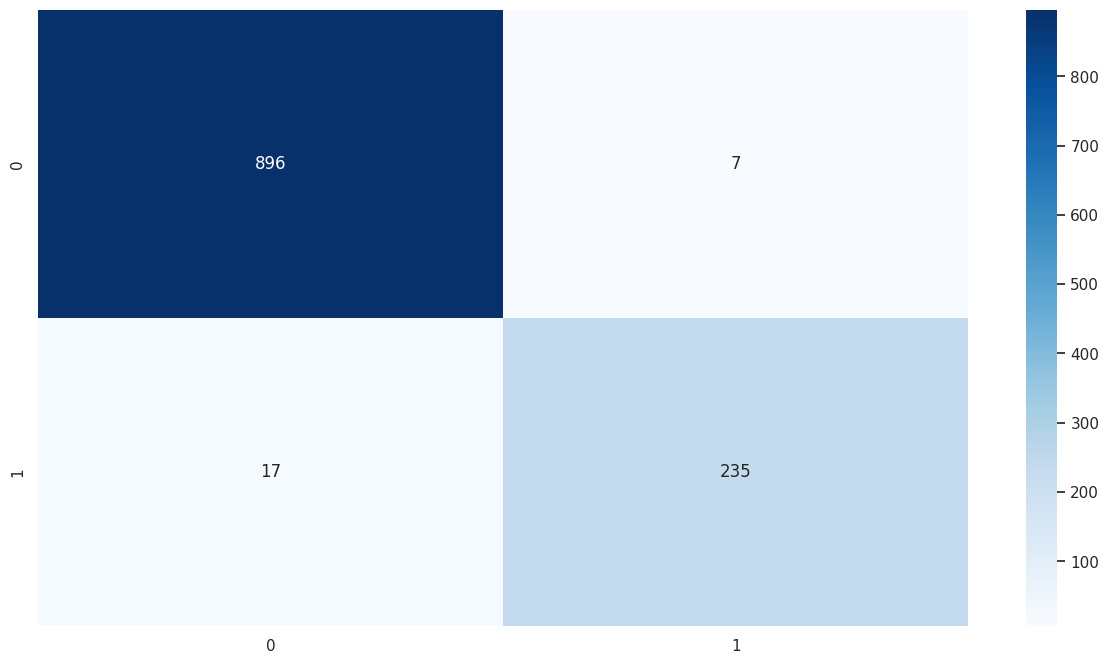

In [32]:
# Stacking Classifier ( Combining all the models )
from sklearn.ensemble import StackingClassifier
sc = StackingClassifier(estimators=[('rf_ada', rf_ada), ('knn', knn), ('nn', nn)], final_estimator=LogisticRegression())
sc.fit(X_train, y_train)
pickle.dump(sc, open('m1_sc_grid.pkl', 'wb'))
show(sc)